In [9]:
# automatically upload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from argparse import Namespace
from collections import defaultdict
import random
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import ray
from ray import tune
from scipy import stats
import sklearn as sk
import torch

from genome_embeddings import corrupt
from genome_embeddings import data_viz
from genome_embeddings import evaluate
from genome_embeddings import models
from genome_embeddings import pathways
from genome_embeddings import pre_process
from genome_embeddings import trainable # import before ray (?)

In [11]:
mode = "Desktop" # "CC" | "Desktop"
# must change local_dir="/Users/natasha/Desktop/TUNE_RESULT_DIR"
#local_dir="/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_04-12-2020/TUNE_RESULT_DIR"

BASE_DIR = '/Users/natasha/Desktop/vae/'
#BASE_DIR ="/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_04-12-2020/TUNE_RESULT_DIR"

if mode == "Desktop":
    settings = Namespace(
        DATA_FP = '/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/data/', 
        SAVE_FP = '/Users/natasha/Desktop/',
        num_epochs = 2,
        num_cpus=5, 
        replacement_threshold = 0.5, # probability over which binarizer converts to a 1
        num_corruptions = 100, # number of corrupted versions of a genome to produce
    )
elif mode == "CC":
    settings = Namespace(
        DATA_FP = '/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_04-12-2020/',
        SAVE_FP = '/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_04-12-2020/',
        num_epochs = 2,
        num_cpus=5, 
        replacement_threshold = 0.5, # probability over which binarizer converts to a 1
        num_corruptions = 100, # number of corrupted versions of a genome to produce
    )
    

In [12]:
tla_to_tnum, keepers = pre_process.genomes2include(mode)
tnum_to_tla = {v:k for k,v in tla_to_tnum.items()}
org_to_kos, n_kos_tot, all_kos = pre_process.load_kos(tla_to_tnum, mode)
org_to_mod_to_kos, mod_sets = pre_process.load_mods(mode)
mod_to_kos = pre_process.create_mod_to_kos(org_to_mod_to_kos)

Total number of bacterial genomes in dataset: 2718
Total number of KOs in dataset: 9874


# Load data needed to make corrupted train + test datasets

In [13]:
tla_to_tnum, keepers = pre_process.genomes2include(mode)

Total number of bacterial genomes in dataset: 2718


In [14]:
create_new = False
from_scratch = False # controls where in creation process to jump in

# Create list of which genomes from KEGG to include in dataset
tla_to_tnum, keepers = pre_process.genomes2include(mode)
tnum_to_tla = {v:k for k,v in tla_to_tnum.items()}
org_to_kos, n_kos_tot, all_kos = pre_process.load_kos(tla_to_tnum, mode)
org_to_mod_to_kos, mod_sets = pre_process.load_mods(mode)
mod_to_kos = pre_process.create_mod_to_kos(org_to_mod_to_kos)

if create_new:
    if from_scratch:
        # Load list mods and KOs per genome
        data, genome_order = pre_process.make_tensor(org_to_mod_to_kos, org_to_kos, n_kos_tot, tla_to_tnum, all_kos)
        torch.save(data, BASE_DIR+"kegg_v2.pt")
        torch.save(genome_order, BASE_DIR+"genome_order.pt")
    else:
        # load data -- tensor (genomes + which KOs are encoded) + genome_order in tensor (tla)
        data = torch.load(BASE_DIR+"kegg_v2.pt")
        genome_order = torch.load(BASE_DIR+"genome_order.pt")
    
    # Create test-train split
    train_genomes, test_genomes = pre_process.train_test_split(keepers) # list of IDs to keep
    train_data = pre_process.prep_data(train_genomes, all_kos, org_to_kos, "train")
    test_data = pre_process.prep_data(test_genomes, all_kos, org_to_kos, "test")
    
    torch.save(all_kos, BASE_DIR+"all_kos_2020-09-29.pt")
    torch.save(org_to_mod_to_kos, BASE_DIR+"org_to_mod_to_kos_2020-09-29.pt")
    torch.save(train_data, BASE_DIR+"kegg_v2_train_2020-09-29.pt")
    torch.save(test_data, BASE_DIR+"kegg_v2_test_2020-09-29.pt")
    torch.save(train_genomes, BASE_DIR+"kegg_v2_train_genomes_2020-09-29.pt")
    torch.save(test_genomes, BASE_DIR+"kegg_v2_test_genomes_2020-09-29.pt")
else:
    all_kos = torch.load(BASE_DIR+"all_kos_2020-09-29.pt")
    org_to_mod_to_kos = torch.load(BASE_DIR+"org_to_mod_to_kos_2020-09-29.pt")
    train_data = torch.load(BASE_DIR+"kegg_v2_train_2020-09-29.pt")
    test_data = torch.load(BASE_DIR+"kegg_v2_test_2020-09-29.pt")
    train_genomes = torch.load(BASE_DIR+"kegg_v2_train_genomes_2020-09-29.pt")
    test_genomes = torch.load(BASE_DIR+"kegg_v2_test_genomes_2020-09-29.pt")

mod_to_ko_clean = pre_process.clean_kos(mod_sets)

Total number of bacterial genomes in dataset: 2718
Total number of KOs in dataset: 9874


In [15]:
train_data.shape

(2430, 9874)

# Filter dataset

In [16]:
# Remove any genomes with fewer than n_min KOs (endosymbionts)
n_min = 500
good_idx_train = train_data.sum(axis=1) >= n_min
good_idx_test = test_data.sum(axis=1) >= n_min
train_data = train_data[good_idx_train,:]
test_data = test_data[good_idx_test,:]

# to numpy for indexing, then back to list for using
train_genomes = list(np.array(train_genomes)[good_idx_train])
test_genomes = list(np.array(test_genomes)[good_idx_test])

In [17]:
# get rid of genomes that encode fewer than n_mods modules
n_mods = 10
train_data, train_genomes = pre_process.remove_duds(train_data, train_genomes, tnum_to_tla, org_to_mod_to_kos, n_mods)
test_data, test_genomes = pre_process.remove_duds(test_data, test_genomes, tnum_to_tla, org_to_mod_to_kos, n_mods)

In [18]:
# Are there any columns that are all zeros in both the train and test sets (TL;DR yes)
good_cols = ((train_data.sum(axis=0) != 0) | (test_data.sum(axis=0) != 0))
train_data = train_data[:,good_cols]
test_data = test_data[:,good_cols]
all_kos = np.array(all_kos)[good_cols].tolist()

In [19]:
(train_data.sum(axis=1) == 0).sum(), (train_data.sum(axis=0) == 0).sum()

(0, 77)

In [20]:
(test_data.sum(axis=1) == 0).sum(), (test_data.sum(axis=0) == 0).sum()

(0, 1595)

In [21]:
train_data.shape, test_data.shape, train_data.shape[0]+test_data.shape[0]

((2305, 9863), (279, 9863), 2584)

In [22]:
train_data.shape[0] + test_data.shape[0]

2584

# Data exploration

In [ ]:
plt.rcParams.update({'font.size': 14})

In [ ]:
mod = 'M00001'
a = list(mod_sets[mod].values())
a.sort(reverse=True)
x_labels = [i for i in range(len(mod_sets[mod].values()))]
plt.bar(x_labels, a)
plt.yscale('log')
plt.title("Variants of module "+mod)
plt.xlabel("Variant (n="+str(len(mod_sets[mod].values()))+" )")
plt.ylabel("Count across all genomes (n="+str(len(org_to_mod_to_kos))+")")
print(max(mod_sets[mod].values()), len(a))

In [ ]:
# Plot the number of KOs encoded by each genome
# Note: this includes genomes excluded from the final dataset!
plt.hist([len(org_to_kos[i]) for i in org_to_kos], 50)
plt.xlabel("Number of KOs per genome")
plt.ylabel("Frequency")
plt.savefig(BASE_DIR+"fig.png")

In [ ]:
# Median, min, and max # KOs per genome
lens = [len(org_to_kos[i]) for i in org_to_kos if i in train_genomes or i in test_genomes]
print(np.median(lens), min(lens), max(lens))

In [ ]:
# Plot the number of modules encoded by each genome
n_genomes = len(org_to_mod_to_kos)
temp = [list(org_to_mod_to_kos[i].keys()) for i in org_to_mod_to_kos]
n_mods_ = len(list(set([item for sublist in temp for item in sublist])))
plt.hist([len(org_to_mod_to_kos[i]) for i in org_to_mod_to_kos], 50)
plt.xlabel("Number of modules per genome")
plt.ylabel("Frequency")
plt.title("Distribution of the # of modules (n="+str(n_mods_)+") per genome (n="+str(n_genomes)+")")

In [ ]:
# a = [len(org_to_mod_to_kos[org]) for org in org_to_mod_to_kos]
# a.sort()
# print("There are "+str(a.count(0))+" genomes with zero modules")

# # Red
# # Rue
# # pvac
# # cgw

In [ ]:
# NOTE THAT SOME GENOMES DO NOT HAVE A SINGLE MOD AND AREN'T EVEN IN THE DICT (n= 2717-2713 = 5)
# E.G.: clap 

In [ ]:
# # Count and plot the number of genomes that encode each module
# mods_count = defaultdict(int)
# for org in org_to_mod_to_kos:
#     for mod in org_to_mod_to_kos[org]:
#         mods_count[mod] += 1
        
# plt.hist(mods_count.values(), 50)
# plt.xlabel("Number of genomes encoding each module")
# plt.ylabel("Frequency")
# plt.title("Distribution of the # of genomes (n="+str(n_genomes)+") encoding each module (n="+str(n_mods)+")")
# plt.yscale('log')
# print("Number of mods encoded in only one genome:",list(mods_count.values()).count(1))

In [ ]:
# # Plot the percentage of genes per genome that contribute to modules
# perc_mod = []
# for org in org_to_mod_to_kos:
#     try:
#         tla = tla_to_tnum[org]
#         n_kos = len(org_to_kos[tla])
#         n_mod_kos = len([org_to_mod_to_kos[org][mod] for mod in org_to_mod_to_kos[org]])
#         perc_mod.append(n_mod_kos/n_kos*100)
#     except: KeyError

# plt.hist(perc_mod, 50)
# plt.xlabel("Percent of KOs contributing to modules")
# plt.ylabel("Frequency")
# plt.title("Distribution of the % of KOs (n_all="+str(n_kos_tot)+") represented by modules (n="+str(n_mods)+") per genome (n="+str(n_genomes)+")")


In [ ]:
# # Percentage of KOs that are / are not part of a module

# kos_in_mods = []

# for org in org_to_mod_to_kos:
#     for mod in org_to_mod_to_kos[org]:
#         kos_in_mods.extend(org_to_mod_to_kos[org][mod])

# kos_in_mods = list(set(kos_in_mods))

# print(len(kos_in_mods), len(all_kos), len(kos_in_mods)/len(all_kos)*100)

In [ ]:
# # Number of KOs that are part of 1 module, 2 modules, 3 modules, etc
# #all_kos # unique list of all KOs
# ko_counter = defaultdict(list)

# for ko in all_kos:
#     for org in org_to_mod_to_kos:
#         for mod in org_to_mod_to_kos[org]:
#             if ko in org_to_mod_to_kos[org][mod]:
#                 if mod not in ko_counter[ko]:
#                     ko_counter[ko].append(mod)

In [ ]:
# ko_counter2 = {}
# for ko in ko_counter:
#     ko_counter2[ko] = len(ko_counter[ko])

# for ko in all_kos:
#     if ko not in ko_counter2:
#         ko_counter2[ko] = 0

In [ ]:
# a = defaultdict(int)
# for i in ko_counter2.values():
#     a[i] += 1
# a, sum(a.values())

In [ ]:
# plt.hist(ko_counter2.values())
# plt.yscale('log')
# plt.title("Number of modules each KO contributes to")
# plt.xlabel("Number of modules")
# plt.ylabel("Frequency (# of KOs)")

# Corrupt input genomes

In [23]:
# corrupt version 1 -- extreme corruption
# 2020-09-04: select 1-10 mods for input
# 2020-10-16_10mods: select 10 mods for input, genomes with fewer than 10 mods are eliminated
# 2020-10-16_1mods: select 1 mods for input, genomes with fewer than 10 mods are eliminated 

new_corrupt = False
n_corrupt = 100
date_to_save = "2021-01-05_"+str(n_mods)+"mods"
date_to_load = "2021-01-05_10mods"

tnum_to_tla = {v:k for k,v in tla_to_tnum.items()}

if new_corrupt:
    print ("Creating new corruptions")
    print (str(n_corrupt),"corruptions per genome")
    print ("With",str(n_mods),"modules as input per genome")
    print ("Saved as",date_to_save)
    #tnum_to_tla = {v:k for k,v in tla_to_tnum.items()}
    corrupted_train, c_train_genomes, train_input_mods = corrupt.corrupt(train_data, train_genomes, n_corrupt, tnum_to_tla, org_to_mod_to_kos, all_kos, mod_to_ko_clean, org_to_kos, n_mods)
    corrupted_test, c_test_genomes, test_input_mods = corrupt.corrupt(test_data, test_genomes, n_corrupt, tnum_to_tla, org_to_mod_to_kos, all_kos, mod_to_ko_clean, org_to_kos, n_mods)
    torch.save(corrupted_train, BASE_DIR+"corrupted_train_"+date_to_save+".pt")
    torch.save(c_train_genomes, BASE_DIR+"c_train_genomes_"+date_to_save+".pt")
    torch.save(corrupted_test, BASE_DIR+"corrupted_test_"+date_to_save+".pt")
    torch.save(c_test_genomes, BASE_DIR+"c_test_genomes_"+date_to_save+".pt")
    torch.save(train_input_mods, BASE_DIR+"train_input_mods_"+date_to_save+".pt")
    torch.save(test_input_mods, BASE_DIR+"test_input_mods_"+date_to_save+".pt")
else:
    print("Loading "+date_to_load)
    corrupted_train = torch.load(BASE_DIR+"corrupted_train_"+date_to_load+".pt")
    c_train_genomes = torch.load(BASE_DIR+"c_train_genomes_"+date_to_load+".pt")
    corrupted_test = torch.load(BASE_DIR+"corrupted_test_"+date_to_load+".pt")
    c_test_genomes = torch.load(BASE_DIR+"c_test_genomes_"+date_to_load+".pt")
    train_input_mods = torch.load(BASE_DIR+"train_input_mods_"+date_to_load+".pt")
    test_input_mods = torch.load(BASE_DIR+"test_input_mods_"+date_to_load+".pt")
    
print ("done")

Loading 2021-01-05_10mods
done


In [24]:
# confirm that there are no all-zero rows
non_zero_idx = corrupted_train.sum(axis=1) > n_min
len(non_zero_idx), corrupted_train.shape[0]

(230500, 230500)

In [25]:
corrupted_train.shape, corrupted_test.shape

(torch.Size([230500, 19726]), torch.Size([27900, 19726]))

# Visualization of final datasets

In [ ]:
fig, labels, y3 = data_viz.plot_tax_dist(c_train_genomes, c_test_genomes, 'Desktop')
plt.savefig(BASE_DIR+"fig_dist.png", bbox_inches='tight')

In [ ]:
def get_lengths(c_genomes, org_to_kos):
    lens = []
    for i in list(set(c_genomes)):
        tnum = tla_to_tnum[i]
        lens.append(len(org_to_kos[tnum]))
    return lens

train_lens = get_lengths(c_train_genomes, org_to_kos)
test_lens = get_lengths(c_test_genomes, org_to_kos)

In [ ]:
# Plot the number of KOs encoded by each genome
fig, ax = plt.subplots()
plt.hist(train_lens, 50, color='#3385ff')
plt.hist(test_lens, 50, color='#bb99ff')
ax.legend(['Train', 'Test'])
plt.xlabel("# annotated genes / genome")
plt.ylabel("Count")
plt.ylim(0,125)
plt.xlim(min(train_lens),max(train_lens)+10)
plt.savefig(BASE_DIR+"fig_ko_dist.pdf", figsize=(370.336, 245.416), bbox_inches='tight')

In [ ]:
# How many modules are there per training genome?
from collections import defaultdict
mods_count = defaultdict(int)
for org in org_to_mod_to_kos:
    if org in c_train_genomes:
        mods_count[org] = len(org_to_mod_to_kos[org])
plt.hist(mods_count.values())
plt.xlabel('Number of modules')
plt.ylabel('Number of genomes')

# HPO w/ Ray Tune: Define and train network

In [3]:
memory = 2000 * 1024 * 1024
object_store_memory = 200 * 1024 * 1024
driver_object_store_memory=100 * 1024 * 1024
ray.shutdown()
ray.init(local_mode=True, memory=memory, 
        object_store_memory=object_store_memory,
        driver_object_store_memory=driver_object_store_memory,
        num_cpus=10)

{}

In [5]:
config = {"num_epochs": 10,
         "kfolds": 10,
         "replacement_threshold": 0.5,
         "nn_layers": tune.choice([1, 2, 3, 4]),
         "batch_size": tune.choice([32, 64, 128, 256]),
          "lr": tune.loguniform(1e-4, 1e-1), 
          "weight_decay": tune.loguniform(1e-5, 1e-2) 
         }

In [4]:
config_corruption = {"num_epochs": 10,
         "kfolds": 10,
         "replacement_threshold": 0.5,
         "nn_layers": 3,
         "batch_size": 128,
          "lr": 0.001, 
          "weight_decay": 0.1
         }

In [5]:
analysis = tune.run(
    trainable.train_AE, 
    name="17_02_2021_40mods",
    config=config_corruption,
    verbose=2, 
    resources_per_trial={
            "cpu": 10,
            "gpu": 0
    },
    #num_samples=20,
    num_samples=1,
    queue_trials=True,
    local_dir="/Users/natasha/Desktop/TUNE_RESULT_DIR",
    #local_dir="/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_01-10-2020/TUNE_RESULT_DIR"
    )

2021-02-19 17:06:33,723	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.59 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:06:33,727	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.59 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:06:33,728	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.59 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


9574
config["replacement_threshold"] 0.5


Trial name,status,loc
train_AE_ba455998,RUNNING,


2021-02-19 17:06:47,222	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-06-47
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.4175658771214026
  test_loss: tensor(5901444.)
  time_since_restore: 13.386452913284302
  time_this_iter_s: 13.386452913284302
  time_total_s: 13.386452913284302
  timestamp: 1613772407
  timesteps_since_restore: 0
  train_f1: 0.26044937117725253
  train_loss: 862428.0625
  training_iteration: 1
  trial_id: ba455998
  


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,13.3865,1


2021-02-19 17:07:13,514	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-07-13
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 2
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.7821556022495828
  test_loss: tensor(1646944.5000)
  time_since_restore: 39.678390979766846
  time_this_iter_s: 26.291938066482544
  time_total_s: 39.678390979766846
  timestamp: 1613772433
  timesteps_since_restore: 0
  train_f1: 0.7963656883571928
  train_loss: 206039.71875
  training_iteration: 2
  trial_id: ba455998
  


2021-02-19 17:07:39,386	WARNING util.py:132 -- The `process_trial` operation took 25.871381282806396 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,39.6784,2


2021-02-19 17:07:39,390	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:07:39,391	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-07-39
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 3
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.8187590374915448
  test_loss: tensor(1431274.7500)
  time_since_restore: 65.55283999443054
  time_this_iter_s: 25.874449014663696
  time_total_s: 65.55283999443054
  timestamp: 1613772459
  timesteps_since_restore: 0
  train_f1: 0.8161399215348548
  train_loss: 180292.8125
  training_iteration: 3
  trial_id: ba455998
  


2021-02-19 17:08:05,836	WARNING util.py:132 -- The `process_trial` operation took 26.444602012634277 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,65.5528,3


2021-02-19 17:08:05,840	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-08-05
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 4
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.8358308929463275
  test_loss: tensor(1302981.7500)
  time_since_restore: 92.00297594070435
  time_this_iter_s: 26.450135946273804
  time_total_s: 92.00297594070435
  timestamp: 1613772485
  timesteps_since_restore: 0
  train_f1: 0.8321076463060921
  train_loss: 175634.953125
  training_iteration: 4
  trial_id: ba455998
  


2021-02-19 17:08:31,844	WARNING util.py:132 -- The `process_trial` operation took 26.002474546432495 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,92.003,4


2021-02-19 17:08:31,848	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-08-31
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 5
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.8476889968137343
  test_loss: tensor(1221154.)
  time_since_restore: 118.01060795783997
  time_this_iter_s: 26.00763201713562
  time_total_s: 118.01060795783997
  timestamp: 1613772511
  timesteps_since_restore: 0
  train_f1: 0.8432223102844518
  train_loss: 155898.484375
  training_iteration: 5
  trial_id: ba455998
  


2021-02-19 17:08:57,952	WARNING util.py:132 -- The `process_trial` operation took 26.102556943893433 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,118.011,5


2021-02-19 17:08:57,955	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:08:57,955	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-08-57
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 6
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.8558133982835224
  test_loss: tensor(1157569.7500)
  time_since_restore: 144.1185450553894
  time_this_iter_s: 26.10793709754944
  time_total_s: 144.1185450553894
  timestamp: 1613772537
  timesteps_since_restore: 0
  train_f1: 0.8621500568688778
  train_loss: 141302.828125
  training_iteration: 6
  trial_id: ba455998
  


2021-02-19 17:09:24,746	WARNING util.py:132 -- The `process_trial` operation took 26.790091037750244 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,144.119,6


2021-02-19 17:09:24,751	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-09-24
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 7
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.8681149702932
  test_loss: tensor(1088555.)
  time_since_restore: 170.91316080093384
  time_this_iter_s: 26.794615745544434
  time_total_s: 170.91316080093384
  timestamp: 1613772564
  timesteps_since_restore: 0
  train_f1: 0.865236120093664
  train_loss: 143246.203125
  training_iteration: 7
  trial_id: ba455998
  


2021-02-19 17:09:51,720	WARNING util.py:132 -- The `process_trial` operation took 26.96825408935547 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,170.913,7


2021-02-19 17:09:51,723	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-09-51
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 8
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.8725472071329143
  test_loss: tensor(1043815.8125)
  time_since_restore: 197.88685607910156
  time_this_iter_s: 26.973695278167725
  time_total_s: 197.88685607910156
  timestamp: 1613772591
  timesteps_since_restore: 0
  train_f1: 0.8685089030066463
  train_loss: 137605.6875
  training_iteration: 8
  trial_id: ba455998
  


2021-02-19 17:10:18,517	WARNING util.py:132 -- The `process_trial` operation took 26.793988943099976 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,197.887,8


2021-02-19 17:10:18,522	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:10:18,523	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-10-18
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 9
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.880125141381947
  test_loss: tensor(995444.4375)
  time_since_restore: 224.68451714515686
  time_this_iter_s: 26.797661066055298
  time_total_s: 224.68451714515686
  timestamp: 1613772618
  timesteps_since_restore: 0
  train_f1: 0.8793845007092537
  train_loss: 129684.390625
  training_iteration: 9
  trial_id: ba455998
  


2021-02-19 17:10:45,665	WARNING util.py:132 -- The `process_trial` operation took 27.14179301261902 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,224.685,9


2021-02-19 17:10:45,668	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-10-45
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 10
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.8855452407778627
  test_loss: tensor(965832.1250)
  time_since_restore: 251.83229303359985
  time_this_iter_s: 27.147775888442993
  time_total_s: 251.83229303359985
  timestamp: 1613772645
  timesteps_since_restore: 0
  train_f1: 0.8826378587923103
  train_loss: 125160.3671875
  training_iteration: 10
  trial_id: ba455998
  


2021-02-19 17:11:12,657	WARNING util.py:132 -- The `process_trial` operation took 26.988362073898315 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,251.832,10


2021-02-19 17:11:12,662	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.6 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-11-12
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 11
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.8905257107520499
  test_loss: tensor(739300.8125)
  time_since_restore: 278.8244569301605
  time_this_iter_s: 26.99216389656067
  time_total_s: 278.8244569301605
  timestamp: 1613772672
  timesteps_since_restore: 0
  train_f1: 0.8941114717950291
  train_loss: 117964.25
  training_iteration: 11
  trial_id: ba455998
  


2021-02-19 17:11:38,406	WARNING util.py:132 -- The `process_trial` operation took 25.743451833724976 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,278.824,11


2021-02-19 17:11:38,410	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:11:38,411	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-11-38
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 12
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.8946814230480032
  test_loss: tensor(884030.8125)
  time_since_restore: 304.5730719566345
  time_this_iter_s: 25.748615026474
  time_total_s: 304.5730719566345
  timestamp: 1613772698
  timesteps_since_restore: 0
  train_f1: 0.8980633471407997
  train_loss: 112338.828125
  training_iteration: 12
  trial_id: ba455998
  


2021-02-19 17:11:45,376	WARNING util.py:132 -- The `process_trial` operation took 6.964585781097412 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,304.573,12


2021-02-19 17:11:45,378	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-11-45
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 13
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.8953844936608972
  test_loss: tensor(892361.0625)
  time_since_restore: 311.54308009147644
  time_this_iter_s: 6.970008134841919
  time_total_s: 311.54308009147644
  timestamp: 1613772705
  timesteps_since_restore: 0
  train_f1: 0.8919992014814206
  train_loss: 116262.390625
  training_iteration: 13
  trial_id: ba455998
  


2021-02-19 17:12:11,194	WARNING util.py:132 -- The `process_trial` operation took 25.815047025680542 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,311.543,13


2021-02-19 17:12:11,200	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-12-11
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 14
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.899283123281731
  test_loss: tensor(857837.2500)
  time_since_restore: 337.3610751628876
  time_this_iter_s: 25.817995071411133
  time_total_s: 337.3610751628876
  timestamp: 1613772731
  timesteps_since_restore: 0
  train_f1: 0.8962350099037318
  train_loss: 110122.8984375
  training_iteration: 14
  trial_id: ba455998
  


2021-02-19 17:12:37,426	WARNING util.py:132 -- The `process_trial` operation took 26.225517749786377 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,337.361,14


2021-02-19 17:12:37,430	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-12-37
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 15
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.902620365529133
  test_loss: tensor(682101.1875)
  time_since_restore: 363.5925328731537
  time_this_iter_s: 26.231457710266113
  time_total_s: 363.5925328731537
  timestamp: 1613772757
  timesteps_since_restore: 0
  train_f1: 0.9069316554529961
  train_loss: 101729.84375
  training_iteration: 15
  trial_id: ba455998
  


2021-02-19 17:13:04,600	WARNING util.py:132 -- The `process_trial` operation took 27.169312953948975 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,363.593,15


2021-02-19 17:13:04,604	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:13:04,605	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-13-04
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 16
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9056587493368656
  test_loss: tensor(813882.5000)
  time_since_restore: 390.76667404174805
  time_this_iter_s: 27.17414116859436
  time_total_s: 390.76667404174805
  timestamp: 1613772784
  timesteps_since_restore: 0
  train_f1: 0.907644971223039
  train_loss: 102484.9296875
  training_iteration: 16
  trial_id: ba455998
  


2021-02-19 17:13:31,544	WARNING util.py:132 -- The `process_trial` operation took 26.938361167907715 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,390.767,16


2021-02-19 17:13:31,549	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-13-31
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 17
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9091803783347803
  test_loss: tensor(790441.2500)
  time_since_restore: 417.710746049881
  time_this_iter_s: 26.944072008132935
  time_total_s: 417.710746049881
  timestamp: 1613772811
  timesteps_since_restore: 0
  train_f1: 0.9107596265913588
  train_loss: 100374.453125
  training_iteration: 17
  trial_id: ba455998
  


2021-02-19 17:13:58,257	WARNING util.py:132 -- The `process_trial` operation took 26.707414865493774 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,417.711,17


2021-02-19 17:13:58,263	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.6 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-13-58
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 18
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9130957115640338
  test_loss: tensor(767893.2500)
  time_since_restore: 444.424516916275
  time_this_iter_s: 26.713770866394043
  time_total_s: 444.424516916275
  timestamp: 1613772838
  timesteps_since_restore: 0
  train_f1: 0.9220754825926821
  train_loss: 88119.0703125
  training_iteration: 18
  trial_id: ba455998
  


2021-02-19 17:14:25,125	WARNING util.py:132 -- The `process_trial` operation took 26.861846923828125 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,444.425,18


2021-02-19 17:14:25,128	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.6 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:14:25,129	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-14-25
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 19
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.916461035322316
  test_loss: tensor(743082.3750)
  time_since_restore: 471.29204177856445
  time_this_iter_s: 26.86752486228943
  time_total_s: 471.29204177856445
  timestamp: 1613772865
  timesteps_since_restore: 0
  train_f1: 0.9177105550047956
  train_loss: 92863.015625
  training_iteration: 19
  trial_id: ba455998
  


2021-02-19 17:14:50,659	WARNING util.py:132 -- The `process_trial` operation took 25.529081106185913 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,471.292,19


2021-02-19 17:14:50,663	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-14-50
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 20
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9204290330993107
  test_loss: tensor(720372.3125)
  time_since_restore: 496.82564401626587
  time_this_iter_s: 25.533602237701416
  time_total_s: 496.82564401626587
  timestamp: 1613772890
  timesteps_since_restore: 0
  train_f1: 0.9213710605677533
  train_loss: 91818.3359375
  training_iteration: 20
  trial_id: ba455998
  


2021-02-19 17:15:17,206	WARNING util.py:132 -- The `process_trial` operation took 26.542216777801514 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,496.826,20


2021-02-19 17:15:17,209	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-15-17
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 21
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9224465320342912
  test_loss: tensor(706076.7500)
  time_since_restore: 523.3726289272308
  time_this_iter_s: 26.546984910964966
  time_total_s: 523.3726289272308
  timestamp: 1613772917
  timesteps_since_restore: 0
  train_f1: 0.9211312973718748
  train_loss: 92875.09375
  training_iteration: 21
  trial_id: ba455998
  


2021-02-19 17:15:43,121	WARNING util.py:132 -- The `process_trial` operation took 25.911617040634155 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,523.373,21


2021-02-19 17:15:43,124	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:15:43,125	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-15-43
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 22
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9231960133679256
  test_loss: tensor(696293.4375)
  time_since_restore: 549.2879359722137
  time_this_iter_s: 25.91530704498291
  time_total_s: 549.2879359722137
  timestamp: 1613772943
  timesteps_since_restore: 0
  train_f1: 0.9271861713478516
  train_loss: 87525.46875
  training_iteration: 22
  trial_id: ba455998
  


2021-02-19 17:16:09,027	WARNING util.py:132 -- The `process_trial` operation took 25.901710271835327 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,549.288,22


2021-02-19 17:16:09,030	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-16-09
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 23
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9282715242361536
  test_loss: tensor(671140.2500)
  time_since_restore: 575.1939549446106
  time_this_iter_s: 25.90601897239685
  time_total_s: 575.1939549446106
  timestamp: 1613772969
  timesteps_since_restore: 0
  train_f1: 0.9275188216614118
  train_loss: 86404.6953125
  training_iteration: 23
  trial_id: ba455998
  


2021-02-19 17:16:35,046	WARNING util.py:132 -- The `process_trial` operation took 26.014894008636475 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,575.194,23


2021-02-19 17:16:35,050	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-16-35
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 24
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9306921642393706
  test_loss: tensor(651564.7500)
  time_since_restore: 601.2126319408417
  time_this_iter_s: 26.01867699623108
  time_total_s: 601.2126319408417
  timestamp: 1613772995
  timesteps_since_restore: 0
  train_f1: 0.9308015191489736
  train_loss: 82472.2421875
  training_iteration: 24
  trial_id: ba455998
  


2021-02-19 17:16:41,323	WARNING util.py:132 -- The `process_trial` operation took 6.271616220474243 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,601.213,24


2021-02-19 17:16:41,325	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-16-41
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 25
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9301784718731583
  test_loss: tensor(515522.3125)
  time_since_restore: 607.4897220134735
  time_this_iter_s: 6.277090072631836
  time_total_s: 607.4897220134735
  timestamp: 1613773001
  timesteps_since_restore: 0
  train_f1: 0.92818947318401
  train_loss: 83885.7109375
  training_iteration: 25
  trial_id: ba455998
  


2021-02-19 17:17:07,500	WARNING util.py:132 -- The `process_trial` operation took 26.174540758132935 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,607.49,25


2021-02-19 17:17:07,503	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:17:07,504	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-17-07
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 26
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9306683037677341
  test_loss: tensor(644962.3750)
  time_since_restore: 633.6671841144562
  time_this_iter_s: 26.177462100982666
  time_total_s: 633.6671841144562
  timestamp: 1613773027
  timesteps_since_restore: 0
  train_f1: 0.9312966802359272
  train_loss: 83719.71875
  training_iteration: 26
  trial_id: ba455998
  


2021-02-19 17:17:34,564	WARNING util.py:132 -- The `process_trial` operation took 27.059285163879395 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,633.667,26


2021-02-19 17:17:34,568	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-17-34
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 27
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.932763453728541
  test_loss: tensor(635009.4375)
  time_since_restore: 660.7307729721069
  time_this_iter_s: 27.063588857650757
  time_total_s: 660.7307729721069
  timestamp: 1613773054
  timesteps_since_restore: 0
  train_f1: 0.9397461138776075
  train_loss: 72404.515625
  training_iteration: 27
  trial_id: ba455998
  


2021-02-19 17:17:59,719	WARNING util.py:132 -- The `process_trial` operation took 25.150454998016357 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,660.731,27


2021-02-19 17:17:59,722	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-17-59
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 28
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9366453875771802
  test_loss: tensor(485050.4375)
  time_since_restore: 685.8856978416443
  time_this_iter_s: 25.154924869537354
  time_total_s: 685.8856978416443
  timestamp: 1613773079
  timesteps_since_restore: 0
  train_f1: 0.9376750266632914
  train_loss: 75779.109375
  training_iteration: 28
  trial_id: ba455998
  


2021-02-19 17:18:26,374	WARNING util.py:132 -- The `process_trial` operation took 26.651323795318604 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,685.886,28


2021-02-19 17:18:26,377	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:18:26,378	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-18-26
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 29
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9390927148055781
  test_loss: tensor(594968.3750)
  time_since_restore: 712.5408821105957
  time_this_iter_s: 26.655184268951416
  time_total_s: 712.5408821105957
  timestamp: 1613773106
  timesteps_since_restore: 0
  train_f1: 0.9428070638513023
  train_loss: 73036.625
  training_iteration: 29
  trial_id: ba455998
  


2021-02-19 17:18:53,568	WARNING util.py:132 -- The `process_trial` operation took 27.18974804878235 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,712.541,29


2021-02-19 17:18:53,572	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-18-53
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 30
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9407713302438244
  test_loss: tensor(577831.)
  time_since_restore: 739.7349269390106
  time_this_iter_s: 27.194044828414917
  time_total_s: 739.7349269390106
  timestamp: 1613773133
  timesteps_since_restore: 0
  train_f1: 0.9415831142243505
  train_loss: 72947.0859375
  training_iteration: 30
  trial_id: ba455998
  


2021-02-19 17:19:20,594	WARNING util.py:132 -- The `process_trial` operation took 27.0219829082489 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,739.735,30


2021-02-19 17:19:20,599	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-19-20
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 31
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9407386984625026
  test_loss: tensor(583919.8750)
  time_since_restore: 766.761125087738
  time_this_iter_s: 27.026198148727417
  time_total_s: 766.761125087738
  timestamp: 1613773160
  timesteps_since_restore: 0
  train_f1: 0.9397328783217826
  train_loss: 74209.7265625
  training_iteration: 31
  trial_id: ba455998
  


2021-02-19 17:19:47,227	WARNING util.py:132 -- The `process_trial` operation took 26.62798500061035 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,766.761,31


2021-02-19 17:19:47,231	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:19:47,232	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-19-47
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 32
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9441956594580917
  test_loss: tensor(552883.8125)
  time_since_restore: 793.3944931030273
  time_this_iter_s: 26.633368015289307
  time_total_s: 793.3944931030273
  timestamp: 1613773187
  timesteps_since_restore: 0
  train_f1: 0.9455388603803117
  train_loss: 70101.34375
  training_iteration: 32
  trial_id: ba455998
  


2021-02-19 17:20:14,173	WARNING util.py:132 -- The `process_trial` operation took 26.94069504737854 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,793.394,32


2021-02-19 17:20:14,177	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-20-14
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 33
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9444184446354907
  test_loss: tensor(549763.7500)
  time_since_restore: 820.3398840427399
  time_this_iter_s: 26.945390939712524
  time_total_s: 820.3398840427399
  timestamp: 1613773214
  timesteps_since_restore: 0
  train_f1: 0.9443329775017695
  train_loss: 71844.828125
  training_iteration: 33
  trial_id: ba455998
  


2021-02-19 17:20:40,579	WARNING util.py:132 -- The `process_trial` operation took 26.401386976242065 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,820.34,33


2021-02-19 17:20:40,584	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-20-40
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 34
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9466998980402525
  test_loss: tensor(532682.3750)
  time_since_restore: 846.7463600635529
  time_this_iter_s: 26.40647602081299
  time_total_s: 846.7463600635529
  timestamp: 1613773240
  timesteps_since_restore: 0
  train_f1: 0.9488471058247882
  train_loss: 65403.9765625
  training_iteration: 34
  trial_id: ba455998
  


2021-02-19 17:21:07,246	WARNING util.py:132 -- The `process_trial` operation took 26.661365032196045 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,846.746,34


2021-02-19 17:21:07,249	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:21:07,250	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-21-07
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 35
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9482322051851428
  test_loss: tensor(519794.5625)
  time_since_restore: 873.4131009578705
  time_this_iter_s: 26.666740894317627
  time_total_s: 873.4131009578705
  timestamp: 1613773267
  timesteps_since_restore: 0
  train_f1: 0.9467532943731872
  train_loss: 67006.1328125
  training_iteration: 35
  trial_id: ba455998
  


2021-02-19 17:21:34,358	WARNING util.py:132 -- The `process_trial` operation took 27.10780692100525 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,873.413,35


2021-02-19 17:21:34,362	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-21-34
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 36
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9472522336834355
  test_loss: tensor(533990.3750)
  time_since_restore: 900.5254189968109
  time_this_iter_s: 27.11231803894043
  time_total_s: 900.5254189968109
  timestamp: 1613773294
  timesteps_since_restore: 0
  train_f1: 0.949101618034974
  train_loss: 66379.9375
  training_iteration: 36
  trial_id: ba455998
  


2021-02-19 17:21:41,389	WARNING util.py:132 -- The `process_trial` operation took 7.026477813720703 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,900.525,36


2021-02-19 17:21:41,391	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-21-41
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 37
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9479407827561654
  test_loss: tensor(520571.3125)
  time_since_restore: 907.5556221008301
  time_this_iter_s: 7.030203104019165
  time_total_s: 907.5556221008301
  timestamp: 1613773301
  timesteps_since_restore: 0
  train_f1: 0.9429170420996267
  train_loss: 70476.515625
  training_iteration: 37
  trial_id: ba455998
  


2021-02-19 17:22:07,795	WARNING util.py:132 -- The `process_trial` operation took 26.403545141220093 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,907.556,37


2021-02-19 17:22:07,798	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:22:07,799	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-22-07
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 38
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9504634819650737
  test_loss: tensor(504755.1562)
  time_since_restore: 933.9620850086212
  time_this_iter_s: 26.406462907791138
  time_total_s: 933.9620850086212
  timestamp: 1613773327
  timesteps_since_restore: 0
  train_f1: 0.9529429093163261
  train_loss: 63825.5234375
  training_iteration: 38
  trial_id: ba455998
  


2021-02-19 17:22:34,652	WARNING util.py:132 -- The `process_trial` operation took 26.85254693031311 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,933.962,38


2021-02-19 17:22:34,655	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-22-34
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 39
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.951659924110231
  test_loss: tensor(499293.0625)
  time_since_restore: 960.819000005722
  time_this_iter_s: 26.85691499710083
  time_total_s: 960.819000005722
  timestamp: 1613773354
  timesteps_since_restore: 0
  train_f1: 0.9564293015782908
  train_loss: 58863.32421875
  training_iteration: 39
  trial_id: ba455998
  


2021-02-19 17:23:01,693	WARNING util.py:132 -- The `process_trial` operation took 27.03686785697937 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,960.819,39


2021-02-19 17:23:01,696	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-23-01
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 40
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9514711811198625
  test_loss: tensor(506753.8750)
  time_since_restore: 987.859699010849
  time_this_iter_s: 27.040699005126953
  time_total_s: 987.859699010849
  timestamp: 1613773381
  timesteps_since_restore: 0
  train_f1: 0.9523842392568213
  train_loss: 62983.515625
  training_iteration: 40
  trial_id: ba455998
  


2021-02-19 17:23:28,085	WARNING util.py:132 -- The `process_trial` operation took 26.3889319896698 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,987.86,40


2021-02-19 17:23:28,088	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:23:28,089	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-23-28
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 41
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9531969773341012
  test_loss: tensor(486085.4375)
  time_since_restore: 1014.252329826355
  time_this_iter_s: 26.39263081550598
  time_total_s: 1014.252329826355
  timestamp: 1613773408
  timesteps_since_restore: 0
  train_f1: 0.955224302419718
  train_loss: 60163.31640625
  training_iteration: 41
  trial_id: ba455998
  


2021-02-19 17:23:55,252	WARNING util.py:132 -- The `process_trial` operation took 27.16292691230774 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1014.25,41


2021-02-19 17:23:55,257	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.6 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-23-55
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 42
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9524496866614558
  test_loss: tensor(495758.9375)
  time_since_restore: 1041.4194478988647
  time_this_iter_s: 27.167118072509766
  time_total_s: 1041.4194478988647
  timestamp: 1613773435
  timesteps_since_restore: 0
  train_f1: 0.9522548444275173
  train_loss: 63513.5078125
  training_iteration: 42
  trial_id: ba455998
  


2021-02-19 17:24:22,432	WARNING util.py:132 -- The `process_trial` operation took 27.174622058868408 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1041.42,42


2021-02-19 17:24:22,435	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.6 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-24-22
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 43
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9540679737919414
  test_loss: tensor(477418.9062)
  time_since_restore: 1068.5991368293762
  time_this_iter_s: 27.179688930511475
  time_total_s: 1068.5991368293762
  timestamp: 1613773462
  timesteps_since_restore: 0
  train_f1: 0.9569194160827678
  train_loss: 59270.3984375
  training_iteration: 43
  trial_id: ba455998
  


2021-02-19 17:24:49,582	WARNING util.py:132 -- The `process_trial` operation took 27.14577603340149 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1068.6,43


2021-02-19 17:24:49,585	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.6 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:24:49,585	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-24-49
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 44
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9550019277770851
  test_loss: tensor(470492.4688)
  time_since_restore: 1095.7486708164215
  time_this_iter_s: 27.149533987045288
  time_total_s: 1095.7486708164215
  timestamp: 1613773489
  timesteps_since_restore: 0
  train_f1: 0.9578602347637453
  train_loss: 58955.4453125
  training_iteration: 44
  trial_id: ba455998
  


2021-02-19 17:25:16,815	WARNING util.py:132 -- The `process_trial` operation took 27.22864270210266 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1095.75,44


2021-02-19 17:25:16,819	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-25-16
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 45
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9566637010108551
  test_loss: tensor(461814.6875)
  time_since_restore: 1122.9816930294037
  time_this_iter_s: 27.233022212982178
  time_total_s: 1122.9816930294037
  timestamp: 1613773516
  timesteps_since_restore: 0
  train_f1: 0.9567855101737092
  train_loss: 58816.95703125
  training_iteration: 45
  trial_id: ba455998
  


2021-02-19 17:25:43,726	WARNING util.py:132 -- The `process_trial` operation took 26.906537294387817 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1122.98,45


2021-02-19 17:25:43,730	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-25-43
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 46
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9567271505907952
  test_loss: tensor(461424.0938)
  time_since_restore: 1149.8932478427887
  time_this_iter_s: 26.91155481338501
  time_total_s: 1149.8932478427887
  timestamp: 1613773543
  timesteps_since_restore: 0
  train_f1: 0.9578685381832598
  train_loss: 57016.62109375
  training_iteration: 46
  trial_id: ba455998
  


2021-02-19 17:26:12,210	WARNING util.py:132 -- The `process_trial` operation took 28.479971885681152 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1149.89,46


2021-02-19 17:26:12,214	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.6 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:26:12,215	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-26-12
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 47
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9571590195653994
  test_loss: tensor(455625.1250)
  time_since_restore: 1178.3772311210632
  time_this_iter_s: 28.483983278274536
  time_total_s: 1178.3772311210632
  timestamp: 1613773572
  timesteps_since_restore: 0
  train_f1: 0.9595179812651509
  train_loss: 56566.58203125
  training_iteration: 47
  trial_id: ba455998
  


2021-02-19 17:26:39,922	WARNING util.py:132 -- The `process_trial` operation took 27.70668315887451 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1178.38,47


2021-02-19 17:26:39,926	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-26-39
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 48
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9582383880881573
  test_loss: tensor(449219.2812)
  time_since_restore: 1206.0887191295624
  time_this_iter_s: 27.711488008499146
  time_total_s: 1206.0887191295624
  timestamp: 1613773599
  timesteps_since_restore: 0
  train_f1: 0.9609754451565642
  train_loss: 54007.87109375
  training_iteration: 48
  trial_id: ba455998
  


2021-02-19 17:26:47,185	WARNING util.py:132 -- The `process_trial` operation took 7.259428024291992 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1206.09,48


2021-02-19 17:26:47,188	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-26-47
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 49
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9591644114143951
  test_loss: tensor(440776.4375)
  time_since_restore: 1213.3525149822235
  time_this_iter_s: 7.263795852661133
  time_total_s: 1213.3525149822235
  timestamp: 1613773607
  timesteps_since_restore: 0
  train_f1: 0.9624031717513567
  train_loss: 53817.33203125
  training_iteration: 49
  trial_id: ba455998
  


2021-02-19 17:27:14,262	WARNING util.py:132 -- The `process_trial` operation took 27.07345414161682 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1213.35,49


2021-02-19 17:27:14,266	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:27:14,267	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-27-14
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 50
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9593595753645846
  test_loss: tensor(438242.6875)
  time_since_restore: 1240.4288909435272
  time_this_iter_s: 27.07637596130371
  time_total_s: 1240.4288909435272
  timestamp: 1613773634
  timesteps_since_restore: 0
  train_f1: 0.9614116638991029
  train_loss: 53286.1796875
  training_iteration: 50
  trial_id: ba455998
  


2021-02-19 17:27:42,513	WARNING util.py:132 -- The `process_trial` operation took 28.245797872543335 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1240.43,50


2021-02-19 17:27:42,517	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-27-42
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 51
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9608244468458201
  test_loss: tensor(435093.3750)
  time_since_restore: 1268.6801719665527
  time_this_iter_s: 28.251281023025513
  time_total_s: 1268.6801719665527
  timestamp: 1613773662
  timesteps_since_restore: 0
  train_f1: 0.9598844677587504
  train_loss: 54223.8515625
  training_iteration: 51
  trial_id: ba455998
  


2021-02-19 17:28:10,310	WARNING util.py:132 -- The `process_trial` operation took 27.792205810546875 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1268.68,51


2021-02-19 17:28:10,314	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-28-10
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 52
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9620949832509466
  test_loss: tensor(419266.3750)
  time_since_restore: 1296.4773530960083
  time_this_iter_s: 27.797181129455566
  time_total_s: 1296.4773530960083
  timestamp: 1613773690
  timesteps_since_restore: 0
  train_f1: 0.9610984831223903
  train_loss: 53200.57421875
  training_iteration: 52
  trial_id: ba455998
  


2021-02-19 17:28:38,459	WARNING util.py:132 -- The `process_trial` operation took 28.144218683242798 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1296.48,52


2021-02-19 17:28:38,465	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:28:38,465	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-28-38
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 53
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9619105861733778
  test_loss: tensor(417997.5625)
  time_since_restore: 1324.6261019706726
  time_this_iter_s: 28.148748874664307
  time_total_s: 1324.6261019706726
  timestamp: 1613773718
  timesteps_since_restore: 0
  train_f1: 0.9643136607244632
  train_loss: 50475.42578125
  training_iteration: 53
  trial_id: ba455998
  


2021-02-19 17:29:05,063	WARNING util.py:132 -- The `process_trial` operation took 26.597748041152954 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1324.63,53


2021-02-19 17:29:05,072	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-29-05
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 54
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9623915217029124
  test_loss: tensor(410239.3750)
  time_since_restore: 1351.2305250167847
  time_this_iter_s: 26.60442304611206
  time_total_s: 1351.2305250167847
  timestamp: 1613773745
  timesteps_since_restore: 0
  train_f1: 0.9644014899031161
  train_loss: 52502.8515625
  training_iteration: 54
  trial_id: ba455998
  


2021-02-19 17:29:32,375	WARNING util.py:132 -- The `process_trial` operation took 27.303039073944092 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1351.23,54


2021-02-19 17:29:32,379	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-29-32
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 55
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9631904253897743
  test_loss: tensor(410782.0625)
  time_since_restore: 1378.542503118515
  time_this_iter_s: 27.311978101730347
  time_total_s: 1378.542503118515
  timestamp: 1613773772
  timesteps_since_restore: 0
  train_f1: 0.962576562490172
  train_loss: 54674.33984375
  training_iteration: 55
  trial_id: ba455998
  


2021-02-19 17:29:59,237	WARNING util.py:132 -- The `process_trial` operation took 26.85804319381714 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1378.54,55


2021-02-19 17:29:59,240	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:29:59,241	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-29-59
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 56
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9626091857359291
  test_loss: tensor(414434.6875)
  time_since_restore: 1405.40438914299
  time_this_iter_s: 26.861886024475098
  time_total_s: 1405.40438914299
  timestamp: 1613773799
  timesteps_since_restore: 0
  train_f1: 0.965374387383215
  train_loss: 51303.2734375
  training_iteration: 56
  trial_id: ba455998
  


2021-02-19 17:30:26,199	WARNING util.py:132 -- The `process_trial` operation took 26.95754599571228 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1405.4,56


2021-02-19 17:30:26,202	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-30-26
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 57
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9635517083630595
  test_loss: tensor(404545.2500)
  time_since_restore: 1432.366178035736
  time_this_iter_s: 26.96178889274597
  time_total_s: 1432.366178035736
  timestamp: 1613773826
  timesteps_since_restore: 0
  train_f1: 0.9665505025421977
  train_loss: 50272.81640625
  training_iteration: 57
  trial_id: ba455998
  


2021-02-19 17:30:53,397	WARNING util.py:132 -- The `process_trial` operation took 27.193592071533203 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1432.37,57


2021-02-19 17:30:53,400	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-30-53
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 58
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9645120432846951
  test_loss: tensor(396596.4688)
  time_since_restore: 1459.5636320114136
  time_this_iter_s: 27.19745397567749
  time_total_s: 1459.5636320114136
  timestamp: 1613773853
  timesteps_since_restore: 0
  train_f1: 0.9635940220089857
  train_loss: 51374.2109375
  training_iteration: 58
  trial_id: ba455998
  


2021-02-19 17:31:21,049	WARNING util.py:132 -- The `process_trial` operation took 27.648491144180298 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1459.56,58


2021-02-19 17:31:21,053	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:31:21,053	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-31-21
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 59
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9652232950428153
  test_loss: tensor(394866.2188)
  time_since_restore: 1487.2159359455109
  time_this_iter_s: 27.65230393409729
  time_total_s: 1487.2159359455109
  timestamp: 1613773881
  timesteps_since_restore: 0
  train_f1: 0.9645109217416217
  train_loss: 52672.40234375
  training_iteration: 59
  trial_id: ba455998
  


2021-02-19 17:31:49,012	WARNING util.py:132 -- The `process_trial` operation took 27.958171129226685 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1487.22,59


2021-02-19 17:31:49,016	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-31-49
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 60
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9660793534415101
  test_loss: tensor(387639.5938)
  time_since_restore: 1515.1786489486694
  time_this_iter_s: 27.96271300315857
  time_total_s: 1515.1786489486694
  timestamp: 1613773909
  timesteps_since_restore: 0
  train_f1: 0.9672959595832685
  train_loss: 47952.0546875
  training_iteration: 60
  trial_id: ba455998
  


2021-02-19 17:31:55,977	WARNING util.py:132 -- The `process_trial` operation took 6.960377216339111 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1515.18,60


2021-02-19 17:31:55,979	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-31-55
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 61
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9664095046296337
  test_loss: tensor(378336.6875)
  time_since_restore: 1522.1437921524048
  time_this_iter_s: 6.965143203735352
  time_total_s: 1522.1437921524048
  timestamp: 1613773915
  timesteps_since_restore: 0
  train_f1: 0.9678719404431227
  train_loss: 49036.1640625
  training_iteration: 61
  trial_id: ba455998
  


2021-02-19 17:32:22,416	WARNING util.py:132 -- The `process_trial` operation took 26.436625957489014 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1522.14,61


2021-02-19 17:32:22,420	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:32:22,421	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-32-22
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 62
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9657160664918437
  test_loss: tensor(387027.)
  time_since_restore: 1548.5833010673523
  time_this_iter_s: 26.43950891494751
  time_total_s: 1548.5833010673523
  timestamp: 1613773942
  timesteps_since_restore: 0
  train_f1: 0.9692162620578112
  train_loss: 46215.64453125
  training_iteration: 62
  trial_id: ba455998
  


2021-02-19 17:32:49,569	WARNING util.py:132 -- The `process_trial` operation took 27.147874116897583 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1548.58,62


2021-02-19 17:32:49,572	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-32-49
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 63
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9659802555882046
  test_loss: tensor(384748.0312)
  time_since_restore: 1575.7361660003662
  time_this_iter_s: 27.152864933013916
  time_total_s: 1575.7361660003662
  timestamp: 1613773969
  timesteps_since_restore: 0
  train_f1: 0.9688557792802716
  train_loss: 46579.32421875
  training_iteration: 63
  trial_id: ba455998
  


2021-02-19 17:33:16,882	WARNING util.py:132 -- The `process_trial` operation took 27.309043884277344 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1575.74,63


2021-02-19 17:33:16,885	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-33-16
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 64
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9666311701987651
  test_loss: tensor(381022.6562)
  time_since_restore: 1603.0490989685059
  time_this_iter_s: 27.31293296813965
  time_total_s: 1603.0490989685059
  timestamp: 1613773996
  timesteps_since_restore: 0
  train_f1: 0.968746811578767
  train_loss: 46633.28515625
  training_iteration: 64
  trial_id: ba455998
  


2021-02-19 17:33:43,938	WARNING util.py:132 -- The `process_trial` operation took 27.051659107208252 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1603.05,64


2021-02-19 17:33:43,942	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:33:43,943	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-33-43
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 65
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9682602162555828
  test_loss: tensor(291976.0938)
  time_since_restore: 1630.104789018631
  time_this_iter_s: 27.055690050125122
  time_total_s: 1630.104789018631
  timestamp: 1613774023
  timesteps_since_restore: 0
  train_f1: 0.969033821217595
  train_loss: 46564.1796875
  training_iteration: 65
  trial_id: ba455998
  


2021-02-19 17:34:10,638	WARNING util.py:132 -- The `process_trial` operation took 26.694314002990723 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1630.1,65


2021-02-19 17:34:10,642	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-34-10
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 66
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9677740720389081
  test_loss: tensor(374694.7812)
  time_since_restore: 1656.8048858642578
  time_this_iter_s: 26.70009684562683
  time_total_s: 1656.8048858642578
  timestamp: 1613774050
  timesteps_since_restore: 0
  train_f1: 0.9686891515831071
  train_loss: 45634.0625
  training_iteration: 66
  trial_id: ba455998
  


2021-02-19 17:34:38,768	WARNING util.py:132 -- The `process_trial` operation took 28.125291109085083 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1656.8,66


2021-02-19 17:34:38,773	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-34-38
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 67
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9677908300560814
  test_loss: tensor(373727.7500)
  time_since_restore: 1684.9350399971008
  time_this_iter_s: 28.130154132843018
  time_total_s: 1684.9350399971008
  timestamp: 1613774078
  timesteps_since_restore: 0
  train_f1: 0.9696801408273497
  train_loss: 45393.12890625
  training_iteration: 67
  trial_id: ba455998
  


2021-02-19 17:35:07,848	WARNING util.py:132 -- The `process_trial` operation took 29.074071884155273 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1684.94,67


2021-02-19 17:35:07,851	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:35:07,851	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-35-07
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 68
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9696643212427127
  test_loss: tensor(358808.8750)
  time_since_restore: 1714.014554977417
  time_this_iter_s: 29.079514980316162
  time_total_s: 1714.014554977417
  timestamp: 1613774107
  timesteps_since_restore: 0
  train_f1: 0.9713388616035158
  train_loss: 43630.125
  training_iteration: 68
  trial_id: ba455998
  


2021-02-19 17:35:37,291	WARNING util.py:132 -- The `process_trial` operation took 29.439133882522583 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1714.01,68


2021-02-19 17:35:37,295	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-35-37
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 69
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9694201910731436
  test_loss: tensor(362684.3438)
  time_since_restore: 1743.4581360816956
  time_this_iter_s: 29.443581104278564
  time_total_s: 1743.4581360816956
  timestamp: 1613774137
  timesteps_since_restore: 0
  train_f1: 0.9699420396295347
  train_loss: 45933.00390625
  training_iteration: 69
  trial_id: ba455998
  


2021-02-19 17:36:05,173	WARNING util.py:132 -- The `process_trial` operation took 27.878138780593872 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1743.46,69


2021-02-19 17:36:05,177	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-36-05
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 70
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.970997541282415
  test_loss: tensor(350267.0625)
  time_since_restore: 1771.3403780460358
  time_this_iter_s: 27.88224196434021
  time_total_s: 1771.3403780460358
  timestamp: 1613774165
  timesteps_since_restore: 0
  train_f1: 0.9725060946205986
  train_loss: 42863.0625
  training_iteration: 70
  trial_id: ba455998
  


2021-02-19 17:36:34,421	WARNING util.py:132 -- The `process_trial` operation took 29.24332904815674 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1771.34,70


2021-02-19 17:36:34,425	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.65 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:36:34,425	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-36-34
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 71
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9695903964577438
  test_loss: tensor(354556.8438)
  time_since_restore: 1800.5881760120392
  time_this_iter_s: 29.247797966003418
  time_total_s: 1800.5881760120392
  timestamp: 1613774194
  timesteps_since_restore: 0
  train_f1: 0.9693669598169942
  train_loss: 45460.88671875
  training_iteration: 71
  trial_id: ba455998
  


2021-02-19 17:37:04,350	WARNING util.py:132 -- The `process_trial` operation took 29.924193143844604 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1800.59,71


2021-02-19 17:37:04,353	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-37-04
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 72
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9701650541713511
  test_loss: tensor(353081.8125)
  time_since_restore: 1830.5171160697937
  time_this_iter_s: 29.928940057754517
  time_total_s: 1830.5171160697937
  timestamp: 1613774224
  timesteps_since_restore: 0
  train_f1: 0.9712251775050433
  train_loss: 43711.33203125
  training_iteration: 72
  trial_id: ba455998
  


2021-02-19 17:37:11,625	WARNING util.py:132 -- The `process_trial` operation took 7.2711780071258545 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1830.52,72


2021-02-19 17:37:11,628	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.65 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-37-11
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 73
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9704656791602749
  test_loss: tensor(354333.0938)
  time_since_restore: 1837.7924230098724
  time_this_iter_s: 7.275306940078735
  time_total_s: 1837.7924230098724
  timestamp: 1613774231
  timesteps_since_restore: 0
  train_f1: 0.9711465129461733
  train_loss: 45345.578125
  training_iteration: 73
  trial_id: ba455998
  


2021-02-19 17:37:39,833	WARNING util.py:132 -- The `process_trial` operation took 28.204375982284546 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1837.79,73


2021-02-19 17:37:39,836	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:37:39,836	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-37-39
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 74
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9711080931884641
  test_loss: tensor(343732.8125)
  time_since_restore: 1865.999634027481
  time_this_iter_s: 28.207211017608643
  time_total_s: 1865.999634027481
  timestamp: 1613774259
  timesteps_since_restore: 0
  train_f1: 0.9717085989149639
  train_loss: 44296.10546875
  training_iteration: 74
  trial_id: ba455998
  


2021-02-19 17:38:07,392	WARNING util.py:132 -- The `process_trial` operation took 27.555517196655273 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1866,74


2021-02-19 17:38:07,396	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-38-07
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 75
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9722464112410263
  test_loss: tensor(338976.5938)
  time_since_restore: 1893.5593740940094
  time_this_iter_s: 27.55974006652832
  time_total_s: 1893.5593740940094
  timestamp: 1613774287
  timesteps_since_restore: 0
  train_f1: 0.972073452223131
  train_loss: 42162.03515625
  training_iteration: 75
  trial_id: ba455998
  


2021-02-19 17:38:35,124	WARNING util.py:132 -- The `process_trial` operation took 27.727933883666992 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1893.56,75


2021-02-19 17:38:35,127	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-38-35
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 76
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9721738644755019
  test_loss: tensor(334415.1562)
  time_since_restore: 1921.2911479473114
  time_this_iter_s: 27.731773853302002
  time_total_s: 1921.2911479473114
  timestamp: 1613774315
  timesteps_since_restore: 0
  train_f1: 0.9745725103492036
  train_loss: 40025.23828125
  training_iteration: 76
  trial_id: ba455998
  


2021-02-19 17:39:03,968	WARNING util.py:132 -- The `process_trial` operation took 28.840343236923218 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1921.29,76


2021-02-19 17:39:03,972	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.65 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:39:03,972	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-39-03
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 77
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.97178283911131
  test_loss: tensor(339040.9375)
  time_since_restore: 1950.1354279518127
  time_this_iter_s: 28.844280004501343
  time_total_s: 1950.1354279518127
  timestamp: 1613774343
  timesteps_since_restore: 0
  train_f1: 0.9741215909423125
  train_loss: 41402.0234375
  training_iteration: 77
  trial_id: ba455998
  


2021-02-19 17:39:33,173	WARNING util.py:132 -- The `process_trial` operation took 29.20044708251953 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1950.14,77


2021-02-19 17:39:33,177	INFO resource_spec.py:212 -- Starting Ray with 9.57 GiB memory available for workers and up to 4.8 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-39-33
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 78
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9727307010117388
  test_loss: tensor(334109.7188)
  time_since_restore: 1979.340031862259
  time_this_iter_s: 29.204603910446167
  time_total_s: 1979.340031862259
  timestamp: 1613774373
  timesteps_since_restore: 0
  train_f1: 0.9758728761247932
  train_loss: 39830.28125
  training_iteration: 78
  trial_id: ba455998
  


2021-02-19 17:40:01,922	WARNING util.py:132 -- The `process_trial` operation took 28.744344234466553 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,1979.34,78


2021-02-19 17:40:01,925	INFO resource_spec.py:212 -- Starting Ray with 9.67 GiB memory available for workers and up to 4.84 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-40-01
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 79
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9718822350146298
  test_loss: tensor(338042.1875)
  time_since_restore: 2008.088840007782
  time_this_iter_s: 28.74880814552307
  time_total_s: 2008.088840007782
  timestamp: 1613774401
  timesteps_since_restore: 0
  train_f1: 0.9735902499843974
  train_loss: 41258.9921875
  training_iteration: 79
  trial_id: ba455998
  


2021-02-19 17:40:30,129	WARNING util.py:132 -- The `process_trial` operation took 28.20371913909912 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2008.09,79


2021-02-19 17:40:30,133	INFO resource_spec.py:212 -- Starting Ray with 9.62 GiB memory available for workers and up to 4.83 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:40:30,133	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-40-30
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 80
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9720345112908165
  test_loss: tensor(334964.4375)
  time_since_restore: 2036.2963180541992
  time_this_iter_s: 28.207478046417236
  time_total_s: 2036.2963180541992
  timestamp: 1613774430
  timesteps_since_restore: 0
  train_f1: 0.9739250669235197
  train_loss: 42481.98046875
  training_iteration: 80
  trial_id: ba455998
  


2021-02-19 17:41:00,116	WARNING util.py:132 -- The `process_trial` operation took 29.982717275619507 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2036.3,80


2021-02-19 17:41:00,120	INFO resource_spec.py:212 -- Starting Ray with 9.42 GiB memory available for workers and up to 4.72 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-41-00
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 81
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9725219711775206
  test_loss: tensor(336902.3125)
  time_since_restore: 2066.2835149765015
  time_this_iter_s: 29.987196922302246
  time_total_s: 2066.2835149765015
  timestamp: 1613774460
  timesteps_since_restore: 0
  train_f1: 0.9734832870695834
  train_loss: 40538.1484375
  training_iteration: 81
  trial_id: ba455998
  


2021-02-19 17:41:29,380	WARNING util.py:132 -- The `process_trial` operation took 29.259429216384888 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2066.28,81


2021-02-19 17:41:29,383	INFO resource_spec.py:212 -- Starting Ray with 9.42 GiB memory available for workers and up to 4.72 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-41-29
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 82
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9730816496373235
  test_loss: tensor(330367.2500)
  time_since_restore: 2095.547231912613
  time_this_iter_s: 29.26371693611145
  time_total_s: 2095.547231912613
  timestamp: 1613774489
  timesteps_since_restore: 0
  train_f1: 0.9720191572005112
  train_loss: 44398.40234375
  training_iteration: 82
  trial_id: ba455998
  


2021-02-19 17:41:58,563	WARNING util.py:132 -- The `process_trial` operation took 29.178751945495605 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2095.55,82


2021-02-19 17:41:58,568	INFO resource_spec.py:212 -- Starting Ray with 9.38 GiB memory available for workers and up to 4.69 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:41:58,568	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-41-58
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 83
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9738376094675316
  test_loss: tensor(323014.3125)
  time_since_restore: 2124.729864835739
  time_this_iter_s: 29.18263292312622
  time_total_s: 2124.729864835739
  timestamp: 1613774518
  timesteps_since_restore: 0
  train_f1: 0.9770033902417045
  train_loss: 37534.28515625
  training_iteration: 83
  trial_id: ba455998
  


2021-02-19 17:42:27,695	WARNING util.py:132 -- The `process_trial` operation took 29.12662386894226 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2124.73,83


2021-02-19 17:42:27,699	INFO resource_spec.py:212 -- Starting Ray with 9.38 GiB memory available for workers and up to 4.7 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-42-27
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 84
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9735632298796947
  test_loss: tensor(320620.7812)
  time_since_restore: 2153.8622708320618
  time_this_iter_s: 29.132405996322632
  time_total_s: 2153.8622708320618
  timestamp: 1613774547
  timesteps_since_restore: 0
  train_f1: 0.9756360372056271
  train_loss: 39938.2265625
  training_iteration: 84
  trial_id: ba455998
  


2021-02-19 17:42:35,149	WARNING util.py:132 -- The `process_trial` operation took 7.449320077896118 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2153.86,84


2021-02-19 17:42:35,151	INFO resource_spec.py:212 -- Starting Ray with 9.33 GiB memory available for workers and up to 4.68 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-42-35
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 85
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9726169616065724
  test_loss: tensor(336297.0312)
  time_since_restore: 2161.315953016281
  time_this_iter_s: 7.45368218421936
  time_total_s: 2161.315953016281
  timestamp: 1613774555
  timesteps_since_restore: 0
  train_f1: 0.9772349243678415
  train_loss: 37626.12890625
  training_iteration: 85
  trial_id: ba455998
  


2021-02-19 17:43:04,516	WARNING util.py:132 -- The `process_trial` operation took 29.364525079727173 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2161.32,85


2021-02-19 17:43:04,519	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.66 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:43:04,520	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-43-04
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 86
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9743846978499978
  test_loss: tensor(319843.6562)
  time_since_restore: 2190.6833069324493
  time_this_iter_s: 29.367353916168213
  time_total_s: 2190.6833069324493
  timestamp: 1613774584
  timesteps_since_restore: 0
  train_f1: 0.9756376001249222
  train_loss: 39689.9296875
  training_iteration: 86
  trial_id: ba455998
  


2021-02-19 17:43:33,668	WARNING util.py:132 -- The `process_trial` operation took 29.1472806930542 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2190.68,86


2021-02-19 17:43:33,671	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-43-33
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 87
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.97520753322884
  test_loss: tensor(314257.0625)
  time_since_restore: 2219.8348479270935
  time_this_iter_s: 29.151540994644165
  time_total_s: 2219.8348479270935
  timestamp: 1613774613
  timesteps_since_restore: 0
  train_f1: 0.976782181317428
  train_loss: 38366.984375
  training_iteration: 87
  trial_id: ba455998
  


2021-02-19 17:44:02,541	WARNING util.py:132 -- The `process_trial` operation took 28.86939311027527 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2219.83,87


2021-02-19 17:44:02,544	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-44-02
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 88
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.974731075122028
  test_loss: tensor(318572.5625)
  time_since_restore: 2248.7081351280212
  time_this_iter_s: 28.873287200927734
  time_total_s: 2248.7081351280212
  timestamp: 1613774642
  timesteps_since_restore: 0
  train_f1: 0.975593983797911
  train_loss: 38734.5078125
  training_iteration: 88
  trial_id: ba455998
  


2021-02-19 17:44:31,570	WARNING util.py:132 -- The `process_trial` operation took 29.025174140930176 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2248.71,88


2021-02-19 17:44:31,573	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:44:31,574	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-44-31
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 89
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9758543837783311
  test_loss: tensor(306027.7500)
  time_since_restore: 2277.7370228767395
  time_this_iter_s: 29.02888774871826
  time_total_s: 2277.7370228767395
  timestamp: 1613774671
  timesteps_since_restore: 0
  train_f1: 0.9748372170295629
  train_loss: 40613.86328125
  training_iteration: 89
  trial_id: ba455998
  


2021-02-19 17:45:00,084	WARNING util.py:132 -- The `process_trial` operation took 28.509416818618774 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2277.74,89


2021-02-19 17:45:00,089	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-45-00
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 90
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9751267841214458
  test_loss: tensor(247105.7969)
  time_since_restore: 2306.2507240772247
  time_this_iter_s: 28.51370120048523
  time_total_s: 2306.2507240772247
  timestamp: 1613774700
  timesteps_since_restore: 0
  train_f1: 0.9769122777455934
  train_loss: 38990.33203125
  training_iteration: 90
  trial_id: ba455998
  


2021-02-19 17:45:28,066	WARNING util.py:132 -- The `process_trial` operation took 27.976482152938843 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2306.25,90


2021-02-19 17:45:28,069	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.65 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-45-28
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 91
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9753907443448149
  test_loss: tensor(311921.4688)
  time_since_restore: 2334.2333059310913
  time_this_iter_s: 27.982581853866577
  time_total_s: 2334.2333059310913
  timestamp: 1613774728
  timesteps_since_restore: 0
  train_f1: 0.9780650251410816
  train_loss: 36905.5859375
  training_iteration: 91
  trial_id: ba455998
  


2021-02-19 17:45:56,641	WARNING util.py:132 -- The `process_trial` operation took 28.57077717781067 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2334.23,91


2021-02-19 17:45:56,644	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:45:56,644	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-45-56
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 92
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9755853245527756
  test_loss: tensor(308786.0625)
  time_since_restore: 2362.8078219890594
  time_this_iter_s: 28.57451605796814
  time_total_s: 2362.8078219890594
  timestamp: 1613774756
  timesteps_since_restore: 0
  train_f1: 0.977420189446571
  train_loss: 38049.4453125
  training_iteration: 92
  trial_id: ba455998
  


2021-02-19 17:46:25,778	WARNING util.py:132 -- The `process_trial` operation took 29.132838010787964 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2362.81,92


2021-02-19 17:46:25,781	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.6 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-46-25
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 93
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9757719481377213
  test_loss: tensor(307242.5625)
  time_since_restore: 2391.9446849823
  time_this_iter_s: 29.136862993240356
  time_total_s: 2391.9446849823
  timestamp: 1613774785
  timesteps_since_restore: 0
  train_f1: 0.9770361114375916
  train_loss: 38375.921875
  training_iteration: 93
  trial_id: ba455998
  


2021-02-19 17:46:55,169	WARNING util.py:132 -- The `process_trial` operation took 29.387691020965576 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2391.94,93


2021-02-19 17:46:55,173	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-46-55
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 94
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.975282803069807
  test_loss: tensor(312394.9062)
  time_since_restore: 2421.3362448215485
  time_this_iter_s: 29.391559839248657
  time_total_s: 2421.3362448215485
  timestamp: 1613774815
  timesteps_since_restore: 0
  train_f1: 0.9783999940944582
  train_loss: 37165.6484375
  training_iteration: 94
  trial_id: ba455998
  


2021-02-19 17:47:24,468	WARNING util.py:132 -- The `process_trial` operation took 29.294437885284424 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2421.34,94


2021-02-19 17:47:24,471	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:47:24,472	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-47-24
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 95
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9758893552391984
  test_loss: tensor(307563.5625)
  time_since_restore: 2450.6351778507233
  time_this_iter_s: 29.298933029174805
  time_total_s: 2450.6351778507233
  timestamp: 1613774844
  timesteps_since_restore: 0
  train_f1: 0.9763854041171776
  train_loss: 38583.15625
  training_iteration: 95
  trial_id: ba455998
  


2021-02-19 17:47:52,599	WARNING util.py:132 -- The `process_trial` operation took 28.126245260238647 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2450.64,95


2021-02-19 17:47:52,602	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.65 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-47-52
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 96
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9756013143836905
  test_loss: tensor(303027.2812)
  time_since_restore: 2478.7657010555267
  time_this_iter_s: 28.130523204803467
  time_total_s: 2478.7657010555267
  timestamp: 1613774872
  timesteps_since_restore: 0
  train_f1: 0.976159172049799
  train_loss: 39369.2734375
  training_iteration: 96
  trial_id: ba455998
  


2021-02-19 17:47:59,606	WARNING util.py:132 -- The `process_trial` operation took 7.0038840770721436 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2478.77,96


2021-02-19 17:47:59,609	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.65 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-47-59
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 97
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9766798488626459
  test_loss: tensor(300799.2188)
  time_since_restore: 2485.7733709812164
  time_this_iter_s: 7.007669925689697
  time_total_s: 2485.7733709812164
  timestamp: 1613774879
  timesteps_since_restore: 0
  train_f1: 0.9793642470252876
  train_loss: 36222.9375
  training_iteration: 97
  trial_id: ba455998
  


2021-02-19 17:48:27,878	WARNING util.py:132 -- The `process_trial` operation took 28.26834988594055 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2485.77,97


2021-02-19 17:48:27,881	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.65 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:48:27,881	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-48-27
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 98
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9747428040487123
  test_loss: tensor(316248.3750)
  time_since_restore: 2514.0446441173553
  time_this_iter_s: 28.271273136138916
  time_total_s: 2514.0446441173553
  timestamp: 1613774907
  timesteps_since_restore: 0
  train_f1: 0.978917999281567
  train_loss: 35310.7578125
  training_iteration: 98
  trial_id: ba455998
  


2021-02-19 17:48:56,235	WARNING util.py:132 -- The `process_trial` operation took 28.353060960769653 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2514.04,98


2021-02-19 17:48:56,238	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-48-56
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 99
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9759045454296975
  test_loss: tensor(304771.8750)
  time_since_restore: 2542.401787996292
  time_this_iter_s: 28.357143878936768
  time_total_s: 2542.401787996292
  timestamp: 1613774936
  timesteps_since_restore: 0
  train_f1: 0.9792803549173739
  train_loss: 35256.3046875
  training_iteration: 99
  trial_id: ba455998
  


2021-02-19 17:49:24,605	WARNING util.py:132 -- The `process_trial` operation took 28.366419076919556 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2542.4,99


2021-02-19 17:49:24,608	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-49-24
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 100
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9772349680065846
  test_loss: tensor(296859.3125)
  time_since_restore: 2570.771826028824
  time_this_iter_s: 28.37003803253174
  time_total_s: 2570.771826028824
  timestamp: 1613774964
  timesteps_since_restore: 0
  train_f1: 0.9770040718722283
  train_loss: 38269.4765625
  training_iteration: 100
  trial_id: ba455998
  


2021-02-19 17:49:54,389	WARNING util.py:132 -- The `process_trial` operation took 29.780386924743652 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2570.77,100


2021-02-19 17:49:54,392	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:49:54,393	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-49-54
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 101
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9769457752287181
  test_loss: tensor(296493.5000)
  time_since_restore: 2600.555998802185
  time_this_iter_s: 29.784172773361206
  time_total_s: 2600.555998802185
  timestamp: 1613774994
  timesteps_since_restore: 0
  train_f1: 0.977970942381725
  train_loss: 36969.36328125
  training_iteration: 101
  trial_id: ba455998
  


2021-02-19 17:50:23,154	WARNING util.py:132 -- The `process_trial` operation took 28.760212898254395 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2600.56,101


2021-02-19 17:50:23,157	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-50-23
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 102
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9782670836359657
  test_loss: tensor(287258.2812)
  time_since_restore: 2629.3206329345703
  time_this_iter_s: 28.764634132385254
  time_total_s: 2629.3206329345703
  timestamp: 1613775023
  timesteps_since_restore: 0
  train_f1: 0.980325761905639
  train_loss: 34510.73046875
  training_iteration: 102
  trial_id: ba455998
  


2021-02-19 17:50:52,221	WARNING util.py:132 -- The `process_trial` operation took 29.06404972076416 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2629.32,102


2021-02-19 17:50:52,225	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-50-52
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 103
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9773555510038517
  test_loss: tensor(291233.7500)
  time_since_restore: 2658.38845205307
  time_this_iter_s: 29.067819118499756
  time_total_s: 2658.38845205307
  timestamp: 1613775052
  timesteps_since_restore: 0
  train_f1: 0.9795518037381096
  train_loss: 35265.9921875
  training_iteration: 103
  trial_id: ba455998
  


2021-02-19 17:51:21,845	WARNING util.py:132 -- The `process_trial` operation took 29.61961603164673 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2658.39,103


2021-02-19 17:51:21,848	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.6 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:51:21,849	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-51-21
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 104
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9779684109409617
  test_loss: tensor(291474.8438)
  time_since_restore: 2688.011859178543
  time_this_iter_s: 29.623407125473022
  time_total_s: 2688.011859178543
  timestamp: 1613775081
  timesteps_since_restore: 0
  train_f1: 0.9803976043278714
  train_loss: 33893.56640625
  training_iteration: 104
  trial_id: ba455998
  


2021-02-19 17:51:51,860	WARNING util.py:132 -- The `process_trial` operation took 30.010967016220093 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2688.01,104


2021-02-19 17:51:51,863	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-51-51
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 105
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9786206459717052
  test_loss: tensor(280966.4062)
  time_since_restore: 2718.02716088295
  time_this_iter_s: 30.01530170440674
  time_total_s: 2718.02716088295
  timestamp: 1613775111
  timesteps_since_restore: 0
  train_f1: 0.980082579278676
  train_loss: 35108.4453125
  training_iteration: 105
  trial_id: ba455998
  


2021-02-19 17:52:21,411	WARNING util.py:132 -- The `process_trial` operation took 29.547311067581177 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2718.03,105


2021-02-19 17:52:21,415	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-52-21
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 106
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9786273912330455
  test_loss: tensor(283266.1875)
  time_since_restore: 2747.578006029129
  time_this_iter_s: 29.5508451461792
  time_total_s: 2747.578006029129
  timestamp: 1613775141
  timesteps_since_restore: 0
  train_f1: 0.9795414641213713
  train_loss: 36562.97265625
  training_iteration: 106
  trial_id: ba455998
  


2021-02-19 17:52:51,390	WARNING util.py:132 -- The `process_trial` operation took 29.973792791366577 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2747.58,106


2021-02-19 17:52:51,393	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.63 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:52:51,394	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-52-51
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 107
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.978485803116012
  test_loss: tensor(283544.5625)
  time_since_restore: 2777.5567309856415
  time_this_iter_s: 29.97872495651245
  time_total_s: 2777.5567309856415
  timestamp: 1613775171
  timesteps_since_restore: 0
  train_f1: 0.9813777952236269
  train_loss: 34059.6015625
  training_iteration: 107
  trial_id: ba455998
  


2021-02-19 17:53:21,392	WARNING util.py:132 -- The `process_trial` operation took 29.99754309654236 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2777.56,107


2021-02-19 17:53:21,395	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.6 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-53-21
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 108
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9787927128623908
  test_loss: tensor(279874.1250)
  time_since_restore: 2807.558610200882
  time_this_iter_s: 30.00187921524048
  time_total_s: 2807.558610200882
  timestamp: 1613775201
  timesteps_since_restore: 0
  train_f1: 0.9786342428498264
  train_loss: 35730.9453125
  training_iteration: 108
  trial_id: ba455998
  


2021-02-19 17:53:28,353	WARNING util.py:132 -- The `process_trial` operation took 6.9572718143463135 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2807.56,108


2021-02-19 17:53:28,355	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-53-28
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 109
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9779370697495424
  test_loss: tensor(286738.9688)
  time_since_restore: 2814.519689798355
  time_this_iter_s: 6.9610795974731445
  time_total_s: 2814.519689798355
  timestamp: 1613775208
  timesteps_since_restore: 0
  train_f1: 0.9783764617602326
  train_loss: 35557.8203125
  training_iteration: 109
  trial_id: ba455998
  


2021-02-19 17:53:57,791	WARNING util.py:132 -- The `process_trial` operation took 29.435518980026245 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2814.52,109


2021-02-19 17:53:57,794	INFO resource_spec.py:212 -- Starting Ray with 9.28 GiB memory available for workers and up to 4.65 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:53:57,795	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-53-57
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 110
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.977895942503861
  test_loss: tensor(286879.1250)
  time_since_restore: 2843.958065032959
  time_this_iter_s: 29.438375234603882
  time_total_s: 2843.958065032959
  timestamp: 1613775237
  timesteps_since_restore: 0
  train_f1: 0.9812978494378541
  train_loss: 33201.23828125
  training_iteration: 110
  trial_id: ba455998
  


2021-02-19 17:54:27,894	WARNING util.py:132 -- The `process_trial` operation took 30.09807014465332 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2843.96,110


2021-02-19 17:54:27,897	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-54-27
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 111
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9781356878779799
  test_loss: tensor(283756.3750)
  time_since_restore: 2874.0605080127716
  time_this_iter_s: 30.102442979812622
  time_total_s: 2874.0605080127716
  timestamp: 1613775267
  timesteps_since_restore: 0
  train_f1: 0.9793472975310858
  train_loss: 35834.9765625
  training_iteration: 111
  trial_id: ba455998
  


2021-02-19 17:54:57,614	WARNING util.py:132 -- The `process_trial` operation took 29.71698522567749 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2874.06,111


2021-02-19 17:54:57,618	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-54-57
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 112
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9792124382531143
  test_loss: tensor(275182.0938)
  time_since_restore: 2903.7813081741333
  time_this_iter_s: 29.720800161361694
  time_total_s: 2903.7813081741333
  timestamp: 1613775297
  timesteps_since_restore: 0
  train_f1: 0.9811119688162989
  train_loss: 33319.375
  training_iteration: 112
  trial_id: ba455998
  


2021-02-19 17:55:26,797	WARNING util.py:132 -- The `process_trial` operation took 29.17911195755005 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2903.78,112


2021-02-19 17:55:26,801	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:55:26,802	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-55-26
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 113
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9789321137223603
  test_loss: tensor(278806.)
  time_since_restore: 2932.964292049408
  time_this_iter_s: 29.182983875274658
  time_total_s: 2932.964292049408
  timestamp: 1613775326
  timesteps_since_restore: 0
  train_f1: 0.9802225689420974
  train_loss: 34822.46484375
  training_iteration: 113
  trial_id: ba455998
  


2021-02-19 17:55:56,452	WARNING util.py:132 -- The `process_trial` operation took 29.649558067321777 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2932.96,113


2021-02-19 17:55:56,455	INFO resource_spec.py:212 -- Starting Ray with 9.33 GiB memory available for workers and up to 4.67 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-55-56
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 114
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9792168392399601
  test_loss: tensor(279142.6250)
  time_since_restore: 2962.618931055069
  time_this_iter_s: 29.65463900566101
  time_total_s: 2962.618931055069
  timestamp: 1613775356
  timesteps_since_restore: 0
  train_f1: 0.9820910858806082
  train_loss: 32465.552734375
  training_iteration: 114
  trial_id: ba455998
  


2021-02-19 17:56:25,887	WARNING util.py:132 -- The `process_trial` operation took 29.431190967559814 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2962.62,114


2021-02-19 17:56:25,890	INFO resource_spec.py:212 -- Starting Ray with 9.33 GiB memory available for workers and up to 4.67 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-56-25
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 115
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9799491953134266
  test_loss: tensor(274789.5000)
  time_since_restore: 2992.053824901581
  time_this_iter_s: 29.43489384651184
  time_total_s: 2992.053824901581
  timestamp: 1613775385
  timesteps_since_restore: 0
  train_f1: 0.9790595378294368
  train_loss: 35172.7734375
  training_iteration: 115
  trial_id: ba455998
  


2021-02-19 17:56:56,056	WARNING util.py:132 -- The `process_trial` operation took 30.165223836898804 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,2992.05,115


2021-02-19 17:56:56,061	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:56:56,061	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-56-56
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 116
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9796193210453685
  test_loss: tensor(274020.2500)
  time_since_restore: 3022.222778081894
  time_this_iter_s: 30.16895318031311
  time_total_s: 3022.222778081894
  timestamp: 1613775416
  timesteps_since_restore: 0
  train_f1: 0.9784281596694002
  train_loss: 36585.86328125
  training_iteration: 116
  trial_id: ba455998
  


2021-02-19 17:57:25,904	WARNING util.py:132 -- The `process_trial` operation took 29.84217095375061 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,3022.22,116


2021-02-19 17:57:25,909	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-57-25
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 117
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.978895463744201
  test_loss: tensor(278391.7188)
  time_since_restore: 3052.0713019371033
  time_this_iter_s: 29.84852385520935
  time_total_s: 3052.0713019371033
  timestamp: 1613775445
  timesteps_since_restore: 0
  train_f1: 0.9800268392756998
  train_loss: 34223.34375
  training_iteration: 117
  trial_id: ba455998
  


2021-02-19 17:57:56,599	WARNING util.py:132 -- The `process_trial` operation took 30.68943428993225 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,3052.07,117


2021-02-19 17:57:56,602	INFO resource_spec.py:212 -- Starting Ray with 9.18 GiB memory available for workers and up to 4.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:57:56,603	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for train_AE_ba455998:
  date: 2021-02-19_17-57-56
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 118
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9800556199716741
  test_loss: tensor(272616.4688)
  time_since_restore: 3082.766247034073
  time_this_iter_s: 30.694945096969604
  time_total_s: 3082.766247034073
  timestamp: 1613775476
  timesteps_since_restore: 0
  train_f1: 0.9800615644364669
  train_loss: 34264.703125
  training_iteration: 118
  trial_id: ba455998
  


2021-02-19 17:58:25,548	WARNING util.py:132 -- The `process_trial` operation took 28.944200038909912 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,3082.77,118


2021-02-19 17:58:25,552	INFO resource_spec.py:212 -- Starting Ray with 9.33 GiB memory available for workers and up to 4.67 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-58-25
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 119
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.979067754210745
  test_loss: tensor(220735.6562)
  time_since_restore: 3111.714798927307
  time_this_iter_s: 28.948551893234253
  time_total_s: 3111.714798927307
  timestamp: 1613775505
  timesteps_since_restore: 0
  train_f1: 0.979935652624038
  train_loss: 34672.5390625
  training_iteration: 119
  trial_id: ba455998
  


2021-02-19 17:58:55,301	WARNING util.py:132 -- The `process_trial` operation took 29.74756669998169 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,total time (s),iter
train_AE_ba455998,RUNNING,192.168.68.106:32472,3111.71,119


2021-02-19 17:58:55,304	INFO resource_spec.py:212 -- Starting Ray with 9.23 GiB memory available for workers and up to 4.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Result for train_AE_ba455998:
  date: 2021-02-19_17-58-55
  done: false
  experiment_id: 69b3fbd9f9144deca47ded7ddb48fff7
  experiment_tag: '0'
  hostname: natashas-MacBook-Pro.local
  iterations_since_restore: 120
  node_ip: 192.168.68.106
  pid: 32472
  test_f1: 0.9810875743168316
  test_loss: tensor(260888.8125)
  time_since_restore: 3141.4677789211273
  time_this_iter_s: 29.75297999382019
  time_total_s: 3141.4677789211273
  timestamp: 1613775535
  timesteps_since_restore: 0
  train_f1: 0.9820663318475144
  train_loss: 32768.3203125
  training_iteration: 120
  trial_id: ba455998
  


2021-02-19 17:58:58,601	WARNING util.py:132 -- The `process_trial` operation took 3.2964859008789062 seconds to complete, which may be a performance bottleneck.
2021-02-19 17:58:58,602	INFO resource_spec.py:212 -- Starting Ray with 16.02 GiB memory available for workers and up to 8.01 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-19 17:58:58,603	WARNING ray_trial_executor.py:361 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.
/usr/local/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Trial name,status,loc,total time (s),iter
train_AE_ba455998,TERMINATED,,3141.47,120


2021-02-19 17:58:58,617	INFO tune.py:352 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


In [ ]:
# print("Best config is:", analysis.get_best_config(metric="test_f1"))

In [ ]:
# analysis.get_best_config(metric="test_f1")

# Single model: Define and train network

In [ ]:
# nn_layers = 3
# weight_decay = 0.1
# lr = 0.001
# batch_size = 128
# kfolds = 10
# num_epochs = 10
# replacement_threshold = 0.5

# kld0, bce0, train_losses, test_losses, train_f1s, test_f1s, model = trainable.train_single_vae(nn_layers, weight_decay, lr, batch_size, kfolds, num_epochs, replacement_threshold, corrupted_train, corrupted_test)


In [ ]:
# version = "0mod"
# torch.save(model.state_dict(), BASE_DIR+"_"+version+"_model.pt")

# torch.save(train_losses, BASE_DIR+"_"+version+"_train_losses.pt")
# torch.save(test_losses, BASE_DIR+"_"+version+"_test_losses.pt")
# torch.save(bce0, BASE_DIR+"_"+version+"_bce0.pt")
# torch.save(kld0, BASE_DIR+"_"+version+"_kld0.pt")
# torch.save(train_f1s, BASE_DIR+"_"+version+"_train_f1s.pt")
# torch.save(test_f1s, BASE_DIR+"_"+version+"_test_f1s.pt")

In [26]:
load_model = True
version = "10mod"
if load_model:
    from genome_embeddings import models
    n_features = int(corrupted_train.shape[1]/2)
    model = models.VariationalAutoEncoder(n_features, 3)
    model.load_state_dict(torch.load(BASE_DIR+"_"+version+"_model.pt"))
    train_losses = torch.load(BASE_DIR+"_"+version+"_train_losses.pt")
    test_losses = torch.load(BASE_DIR+"_"+version+"_test_losses.pt")
    train_f1s = torch.load(BASE_DIR+"_"+version+"_train_f1s.pt")
    test_f1s = torch.load(BASE_DIR+"_"+version+"_test_f1s.pt")
    bce0 = torch.load(BASE_DIR+"_"+version+"_bce0.pt")
    kld0 = torch.load(BASE_DIR+"_"+version+"_kld0.pt")

# Evaluate model performance

### Generate predictions on test set

In [27]:
# 1-10 modules per input genome: 0.74
# 1 module per input genome: 0.64
# 10 modules per input genome: 0.81
n_features = int(corrupted_test.shape[1]/2)
corrupted = corrupted_test[:,:n_features]
uncorrupted = corrupted_test[:,n_features:]

In [28]:
new_preds = False

model.eval()

if new_preds:
    with torch.no_grad():
        pred = model.forward(corrupted)[0].detach()
    binary_pred = evaluate.eval_binarize(pred, 0.5)
    torch.save(pred, BASE_DIR+"_preds.pt")
    torch.save(binary_pred, BASE_DIR+"_binary_preds.pt")
else:
    pred = torch.load(BASE_DIR+"_preds.pt")
    binary_pred = torch.load(BASE_DIR+"_binary_preds.pt")

### Investigate test set F1 score (micro-average) and calculate TNs, FPs, FNs, TPs

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, binary_pred, zero_division=0, average='micro')
print("Test set F1 score",f1)

In [ ]:
f1s, fig = evaluate.test_f1s(uncorrupted, binary_pred)
plt.savefig(BASE_DIR+"f1_dist.pdf", bbox_inches='tight')

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, binary_pred)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
tns[0]

### Examine at BCE vs KLD loss

In [ ]:
# Plot BCE and KLD vs experience
data_viz.kld_vs_bce(kld0,bce0)

### Plot learning curves

In [ ]:
fig = data_viz.learning_curve(train_losses, test_losses, train_f1s, test_f1s)
plt.savefig(BASE_DIR+"learning_curves.pdf", bbox_inches='tight')

### Plot ROC curve and generate AUC score (micro-average)

In [ ]:
num_features = int(corrupted_test.shape[1]/2)
true_genomes = corrupted_test[:,num_features:]
fig = data_viz.my_roc_curve(true_genomes.numpy(), pred.numpy())
fig.savefig(BASE_DIR+"roc_fig.pdf", dpi=200, bbox_inches='tight')

### Are the input genes present in the output?

There are 6675 instance of inputs being 100% present in output
This is out of 27900 instances or 23.92% of cases
There are 23774 instance of inputs being >=90% present in output (85.21%)


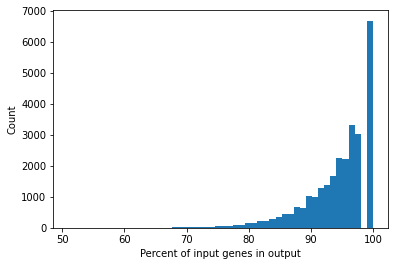

In [21]:
# relabel y axis by % rather than count
fig, _ = evaluate.compare_in_n_out(binary_pred, corrupted)
fig.savefig(BASE_DIR+"input_vs_output.pdf", bbox_inches='tight', dpi=200)

### What are the best and worst performing instances?

In [ ]:
# babt = Brucella abortus
idx_best = f1s.index(max(f1s))
tla_best = c_test_genomes[idx_best]
idx_best, tla_best, f1s[idx_best], tla_to_tnum[tla_best]

In [ ]:
# nmv = Nitrospira moscoviensis
# seny = Pectobacteriaceae sodalis (Gammaprot), endosymbiont of Henestaris halophilus
# bmx
idx_worst = f1s.index(min(f1s))
tla_worst = c_test_genomes[idx_worst]
idx_worst, tla_worst, f1s[idx_worst], tla_to_tnum[tla_worst]

### For the best scoring instance, plot pixel diagram

In [ ]:
idx = idx_best
fig = data_viz.genome_heatmap2(corrupted_test, idx, model, f1s, tns, fps, fns, tps, binary_pred)
fig.savefig(BASE_DIR+"fig4.pdf", bbox_inches='tight', dpi=200)

In [ ]:
print("Num genes on in uncorrupted idx_best genome", torch.sum(uncorrupted[idx_best,:]))
print("Num genes off in uncorrupted idx_best genome", n_features - torch.sum(uncorrupted[idx_best,:]))
print("Num genes on in corrupted idx_best genome", torch.sum(corrupted[idx_best,:]))

In [ ]:
fig = evaluate.snowplot(f1s, c_test_genomes, tns, fps, fns, tps, uncorrupted, corrupted, idx_best)
fig.savefig(BASE_DIR+"barh.pdf", bbox_inches='tight', dpi=200)

### For the worst scoring instance, plot pixel diagram

In [ ]:
idx = idx_worst
fig = data_viz.genome_heatmap2(corrupted_test, idx, model, f1s, tns, fps, fns, tps, binary_pred)
fig.savefig(BASE_DIR+"fig4.png", bbox_inches='tight', dpi=200)

In [ ]:
# print median TNs, FPs, FNs, TPs
np.median(tns), np.median(fps), np.median(fns), np.median(tps)

### How does the model perform on inputs originating from different phyla

In [ ]:
# get dicts to map genome tla back to list of phylum, class, etc
train_tax_dict, test_tax_dict = data_viz.tax_distribution(c_train_genomes, c_test_genomes, 'Desktop')

In [ ]:
count_per_phy = defaultdict(int)
for tnum in test_genomes:
    tla = tnum_to_tla[tnum]
    phylum = test_tax_dict[tla][1]
    if phylum == 'Proteobacteria':
        phylum = test_tax_dict[tla][2]
    count_per_phy[phylum] += 1
count_per_phy

In [ ]:
train_phyla, test_phyla = evaluate.f1s_per_phylum(train_tax_dict, test_tax_dict, c_test_genomes, f1s)

In [ ]:
# number of phyla in train + test sets
len(set(list(train_phyla.keys()) + list(test_phyla.keys())))

In [ ]:
# Bars represent median absolute deviation
fig_save_for_later = evaluate.plot_f1_per_phylum(test_phyla, (5,10))
fig_save_for_later.savefig(BASE_DIR+"f1_per_phylum.png", dpi=200, bbox_inches='tight')

In [ ]:
# Are the results between phyla statistically significant?
stats.kruskal(*test_phyla.values())

In [ ]:
fig = evaluate.plot_count_vs_f1s(train_phyla, test_phyla)

There appears to be an effect of number of training genomes / phylum on test set per phylum F1 score 

### How many times is each mod used in the various corrupted inputs?

In [ ]:
# Number of times each mod occurs in the training set corrupted genomes
train_out = evaluate.train_out(train_input_mods)

In [ ]:
fig = evaluate.plot_train_count_hist(train_out)

### How does genome size correlate with F1 score

In [ ]:
# x-axis = # genes in input genome
# y-axis = F1 score of reconstructed genomes

In [ ]:
n_genes_uncorrupted = torch.sum(uncorrupted, 1).numpy().tolist() # get sum of each row

In [ ]:
plt.scatter(n_genes_uncorrupted, f1s, marker='.', s = 1)
plt.xlabel("# genes in uncorrupted genome")
plt.ylabel("F1 score")

In [ ]:
n_genes_corrupted = torch.sum(corrupted, 1).numpy().tolist() # get sum of each row

In [ ]:
plt.scatter(n_genes_corrupted, f1s, marker='.', s = 1)
plt.xlabel("# genes in corrupted input")
plt.ylabel("F1 score")

### How much variance is there in the F1 score of genomes encoding certain modules?
Do some modules / lifestyles get reconstructed better than others?

In [ ]:
process_to_mod, mod_to_proc = evaluate.map_proc_mod()

In [ ]:
#fig, done = evaluate.plot_mod_count_vs_f1(test_input_mods, c_test_genomes, train_input_mods, f1s)

In [ ]:
#fig = evaluate.plot_mod_vs_f1(test_input_mods, f1s)

In [ ]:
# Plot whether number of modules in process correlates with F1 score
# More interchangeable options = worse performance?

In [ ]:
subprocess_to_mod, mod_to_subproc = evaluate.map_subproc_mod()

In [ ]:
# fig = evaluate.plot_metab_pathway_f1(subprocess_to_mod, test_input_mods, f1s)

### Analyze F1 scores of actual KOs

In [ ]:
### THIS MUST BE USED IN MULTIPLE PLACES
ko_f1s = []
for i in range(uncorrupted.shape[1]): # for every column
    f1 = sk.metrics.f1_score(uncorrupted[:,i], binary_pred[:,i], zero_division=0)
    ko_f1s.append(f1)

In [ ]:
zeros = 0
for i in ko_f1s:
    if i == 0:
        zeros += 1
print(zeros, len(ko_f1s), zeros/len(ko_f1s)*100)

In [ ]:
# In the training set, how many KOs are always zero?
zeros_train = train_data.sum(axis=0) > 0
n_ones = np.sum(zeros_train)
n_zeros_train = len(zeros_train) - n_ones
print("There are",n_zeros_train,"genes that are always off in the training set")

In [ ]:
fig = plt.figure()
plt.hist(ko_f1s, bins = 50)
plt.xlabel("F1 score per gene")
plt.ylabel("Count")

In [ ]:
# gene occurence in uncorrupted ds vs F1 score
#ko_counts = torch.sum(uncorrupted, 0)
# get gene occurence in uncorrupted training set
tr_uncorrupted = corrupted_train[:,n_features:]
ko_counts = torch.sum(tr_uncorrupted, 0)

fig, ax = plt.subplots()
plt.scatter(ko_counts, ko_f1s, marker='.', s = 1)
ax.set_xlim(0, tr_uncorrupted.shape[0])
ax.set_ylim(0,1)
plt.xlabel("gene count in uncorrupted train set")
plt.ylabel("per gene test F1 score")
plt.xticks(rotation=-70)
print("max KO count:",int(max(ko_counts)), ", total number of training genomes:",tr_uncorrupted.shape[0])

### Generate figure for paper

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))

phylum_f1s = [np.median(test_phyla[i]) for i in test_phyla]
phylum_count = [train_phyla[i] for i in test_phyla]
ax1.scatter(phylum_count, phylum_f1s)
ax1.set_xlabel("Number of genomes in train set")
ax1.set_ylabel("F1 score on test set")
ax1.set_xscale('log')

tr_uncorrupted = corrupted_train[:,n_features:]
ko_counts = torch.sum(tr_uncorrupted, 0)
ax2.scatter(ko_counts, ko_f1s, marker='.', s = 1)
ax2.set_xlim(0, tr_uncorrupted.shape[0])
ax2.set_ylim(0,1)
ax2.set_xlabel("Gene count in uncorrupted train set")
ax2.set_ylabel("Ger gene test F1 score")

n_genes_uncorrupted = torch.sum(uncorrupted, 1).numpy().tolist() # get sum of each row
ax3.scatter(n_genes_uncorrupted, f1s, marker='.', s = 1)
ax3.set_xlabel("# genes in original test genome")
ax3.set_ylabel("F1 score on test set")

plt.tight_layout()

fig.savefig(BASE_DIR+"bio_insights_contd.pdf", dpi=200, bbox_inches='tight')

In [ ]:
# F1 score on KOs + what metab pathway they are part of

In [ ]:
fig = evaluate.plot_metab_pathway_f1_v2(process_to_mod, mod_to_ko_clean, all_kos, ko_f1s, (7,5))

In [ ]:
# can also do horizontal boxplot with fig = evaluate.plot_metab_pathway_f1_v2
fig, proc_to_ko_F1s = evaluate.plot_metab_pathway_f1_v2_horizontal(subprocess_to_mod, mod_to_ko_clean, all_kos, ko_f1s, (5,10))
#fig.savefig(BASE_DIR+"f1_per_proc.png", dpi=200, bbox_inches='tight')

In [ ]:
stats.kruskal(*proc_to_ko_F1s.values())

In [ ]:
### How does the model do on different types of genes (kinases vs transferases, etc) 

In [ ]:
fig = evaluate.bio_insights_fig(test_phyla, subprocess_to_mod, all_kos, ko_f1s, mod_to_ko_clean)
fig.savefig(BASE_DIR+"bio_insights_fig.pdf", dpi=200, bbox_inches='tight')

### How does the count of each mod in training set (pre-corruption) correlate with median F1 score

In [ ]:
fig = evaluate.plot_mod_count_vs_f1_v2(test_input_mods, f1s, train_out)

# Qualitatively compare distance of real vs generated genomes

In [29]:
# Generate 100 genomes using random sets of 10 modules
new_genomes = False

if new_genomes:
    from datetime import date
    date = date.today()
    generated, generated_inputs = evaluate.generate_genomes(100, all_kos, mod_to_ko_clean, 10, model)
    torch.save(generated, BASE_DIR+"generated_genomes_"+str(date)+".pt")
    torch.save(generated_inputs, BASE_DIR+"generated_genome_inputs_"+str(date)+".pt")
else:
#     generated = torch.load(BASE_DIR+"generated_genomes_11_01_2020.pt")
#     generated_inputs = torch.load(BASE_DIR+"generated_genome_inputs_11_01_2020.pt")
    generated = torch.load(BASE_DIR+"generated_genomes_2021-02-01.pt")
    generated_inputs = torch.load(BASE_DIR+"generated_genome_inputs_2021-02-01.pt")

### Plot PCA of Jaccard similarity between genomes, using Hamming distances as a metric

idx 292 Num genes in selected genome 2015


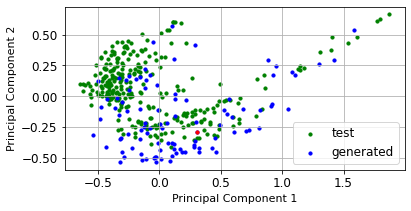

In [30]:
idx = random.randint(279, 379) # assumes 279 test genomes + 100 generated genomes, 0-indexed
#idx = 368 # pathogen
#idx = 282 # heme biosyn
idx = 292
gen_idx = idx - test_data.shape[0] # generated genomes follow test set genomes in tensor
print("idx",str(idx),"Num genes in selected genome", int(torch.sum(generated[gen_idx])))
plt.rcParams.update({'font.size': 12})
#fig = evaluate.plot_dist(generated_genomes, all_kos, mod_to_ko_clean, model, test_data)
fig = evaluate.plot_dist(generated, all_kos, mod_to_ko_clean, model, test_data, idx)
fig.savefig(BASE_DIR+"pca_jaccard.pdf", dpi=200, bbox_inches='tight');

In [32]:
gen_corrupted = np.zeros((len(generated_inputs), n_features))

for i in range(len(generated_inputs)):
    kos_in = generated_inputs[i][1] # get KOs used as inputs
    ko_idx = [all_kos.index(i) for i in kos_in] # get col index of those KOs in the data tensor
    gen_corrupted[i][ko_idx] = 1 # turn on genes at those indices

gen_corrupted = torch.Tensor(gen_corrupted).type(torch.LongTensor)

There are 100 instance of inputs being 100% present in output
This is out of 100 instances or 100.0% of cases
There are 100 instance of inputs being >=90% present in output (100.0%)


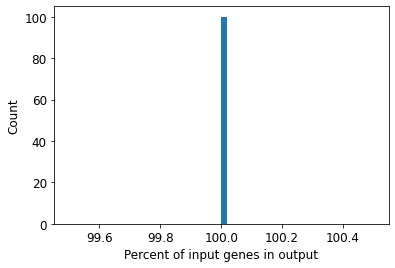

In [33]:
fig, out = evaluate.compare_in_n_out(generated, gen_corrupted)

In [ ]:
len(generated_inputs)

In [ ]:
# Make list of KOs in generated genome
gen_ko_idx = [int(i) for i in (generated[gen_idx] == 1).nonzero()]
gen_kos = [all_kos[i] for i in gen_ko_idx]
len(gen_kos)

In [ ]:
# Assess ribosomal completeness
pathways.confirm_ribosome(gen_kos)

In [ ]:
# Assess rRNA gene completeness
pathways.confirm_rrna(gen_kos)

In [ ]:
assert 'K21254' in gen_kos

In [ ]:
# for each mod number, get its name
mod_to_name = pre_process.mod_names()

In [ ]:
def mod_completeness(genome_vector, mod_to_ko_clean, mod):
    count = 0
    for i in mod_to_ko_clean[mod]:
        if i in genome_vector:
            count += 1
        else:
            print("missing", i)
    print(count,"/",len(mod_to_ko_clean[mod]),"genes in the mod are present")

In [ ]:
for mod in generated_inputs[gen_idx][0]:
    print(mod, mod_to_name[mod])
    print(mod_to_ko_clean[mod])
    mod_completeness(gen_kos, mod_to_ko_clean, mod)
    print("--------------------------------------------")

In [ ]:
save_to = BASE_DIR+"prot_out_"+str(gen_idx)+".txt"

with open(BASE_DIR+'seq_dict.pkl', 'rb') as handle:
    seq_dict = pickle.load(handle)

with open(save_to, 'w') as handle:
    for prot in gen_kos:
        handle.write(">"+prot+"\n")
        handle.write(seq_dict[prot]+"\n")

print(gen_idx)

In [ ]:
# Prepare input to KEGG Mapper
for i, ko in enumerate(gen_kos):
    print("gene"+str(i), ko)

### Distributions of genes and modules per genome for real vs generated genomes

In [ ]:
def complete_mods(generated, all_kos, mod_to_ko_clean):
    gen_kos = defaultdict(list)
    for i, row in enumerate(generated):
        for j in range(len(row)):
            if row[j] == 1:
                gen_kos[i].append(all_kos[j])

    gen_mods = defaultdict(list)
    for genome in gen_kos:
        my_kos = gen_kos[genome]

        for mod in mod_to_ko_clean:
            complete = True
            for ko in mod_to_ko_clean[mod]:
                if ko not in my_kos: 
                    complete = False

            if complete:
                gen_mods[genome].append(mod)
                
    return gen_mods

In [ ]:
def mod_freqs(mod_to_ko_clean, test_data, generated):

    real_mod_freq = []
    gen_mod_freq = []
    for mod in mod_to_ko_clean:
        real_count = 0
        gen_count = 0
        for genome in gen_mods:
            if mod in gen_mods[genome]:
                gen_count += 1
            if mod in real_mods[genome]:
                real_count += 1
        real_mod_freq.append(real_count / len(test_data))
        gen_mod_freq.append(gen_count / len(generated))

    # sort in descending order of real genome mods
    real_mod_freq, gen_mod_freq = zip(*sorted(zip(real_mod_freq, gen_mod_freq), reverse=True))

    return real_mod_freq, gen_mod_freq

In [ ]:
gen_mods = complete_mods(generated, all_kos, mod_to_ko_clean)
real_mods = complete_mods(test_data, all_kos, mod_to_ko_clean)
gen_mod_lens = [len(gen_mods[i]) for i in gen_mods]
real_mod_lens = [len(real_mods[i]) for i in gen_mods]

real_mod_freq, gen_mod_freq = mod_freqs(mod_to_ko_clean, test_data, generated)
labels = [i for i in range(len(gen_mod_freq))]

len_gen = []
for genome in generated:
    len_gen.append(torch.sum(genome))
len_real = []
for genome in test_data:
    len_real.append(np.sum(genome))

In [ ]:
plt.rcParams.update({'font.size': 18})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
#plt.yticks(fontsize=20) 

# Plot number of genes per genome
ax1.hist(len_real, 50, color='g', alpha=0.5)
ax1.hist(len_gen, 50, color='b', alpha=0.5)
#ax1.legend(['Real', 'Generated'])
ax1.set_xlabel("Number of genes")
ax1.set_ylabel("Genome count")

# Plot number of complete mods per genome
ax2.hist(gen_mod_lens, 50, color='b', alpha=0.5)
ax2.hist(real_mod_lens, 50, color='g', alpha=0.5)
#ax2.legend(['Real', 'Generated'])
ax2.set_xlabel("Number of complete modules")
ax2.set_ylabel("Genome count")

# Plot the fraction of genomes encoding each mod
ax3.bar(labels, gen_mod_freq, color='b', alpha=0.5)
ax3.bar(labels, real_mod_freq, color='g', alpha=0.5)
ax3.legend(['Real', 'Generated'])
ax3.set_xlabel("Module")
ax3.set_ylabel("Fraction of genomes \n encoding module")
ax3.set_xlim(0,len(labels))

plt.tight_layout()

fig.savefig(BASE_DIR+"count_dists.pdf", dpi=200, bbox_inches='tight')
fig.savefig(BASE_DIR+"count_dists.png", dpi=200, bbox_inches='tight')

### Create files needed to infer and visualize a dendrogram based on gene prescence/abscence
Will use phylip to infer a parsimony-based dendrogram (mix program)

Will use iTOL for visualization (display, add colour strips, remove taxon labels)

In [ ]:
barc_vec = evaluate.arch_root(all_kos)

In [ ]:
# Reformat tensor for input to phylip
df = evaluate.df_for_phylip(generated, test_data, test_genomes, all_kos)
df = df.append(pd.DataFrame({col: [val] for col, val in zip(df.columns, barc_vec)}, ['outgroup_T04065']))
phylum_dict = evaluate.write_out_for_phylip(BASE_DIR, df, tnum_to_tla, test_tax_dict) # phylip_in.txt
#df.to_csv(BASE_DIR+'generated_genomes.csv', index = True)

In [ ]:
# Sanity check
same = True
for i in range(len(generated[13])):
    if int(df.iloc[292][i]) != int(generated[13][i]):
        same = False
same

In [ ]:
# Find "phylip-3.695-vol", double click "mix" program
# Enter file name with path to dir ---> delete space at the end of the file name

In [ ]:
# For parsimony dendrogram: generate real genomes' phylum-level colour strip file for iTOL 
phyla_colours = evaluate.get_phyla_colours()
evaluate.colour_real_itol(BASE_DIR, phyla_colours, phylum_dict) # vae_dendro_colours_real.txt
#colour = tuple(np.random.randint(256, size=3))

In [ ]:
# For parsimony dendrogram: generate generated genomes' colour strip file for iTOL
evaluate.colour_generated_itol(BASE_DIR, phylum_dict) # vae_dendro_colours_generated.txt

# Baseline models

In [ ]:
import sklearn as sk
from sklearn.metrics import confusion_matrix

### Baseline 1: randomly turn on n_rand bits

In [ ]:
new = False

if new:
    print("Generating new baseline 1")
    baseline1 = evaluate.baseline1(corrupted_train, org_to_mod_to_kos, org_to_kos, tla_to_tnum, c_train_genomes, corrupted_test)
    torch.save(baseline1, BASE_DIR+"baseline1.pt")
else:
    print("Loading previously made baseline 1")
    baseline1 = torch.load(BASE_DIR+"baseline1.pt")

In [ ]:
baseline1.shape

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline1, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline1)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline1.numpy())

### Baseline 2: randomly turn on n_rand bits with the highest probability of being on across the entire training set

In [ ]:
new = True

if new:
    print("Generating new baseline 2")
    baseline2 = evaluate.baseline2(corrupted_test, org_to_mod_to_kos, org_to_kos, tla_to_tnum, c_train_genomes, corrupted_test)
    torch.save(baseline2, BASE_DIR+"baseline2.pt")
else:
    print("Loading previously made baseline 2")
    baseline2 = torch.load(BASE_DIR+"baseline2.pt")
    

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline2, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline2)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline2.numpy())

### Baseline 3: Create predictions using an untrained version of the VAE model

In [ ]:
new = True

if new:
    print("Generating new baseline 3")
    n_features = int(corrupted_test.shape[1]/2)
    fake_model = models.VariationalAutoEncoder(n_features, 3)
    fake_model.eval()
    with torch.no_grad():
        pred = fake_model.forward(corrupted_test[:,:n_features])[0].detach()
    baseline3 = evaluate.eval_binarize(pred, 0.5)
    torch.save(baseline3, BASE_DIR+"baseline3.pt")
else:
    print("Loading previously made baseline 3")
    baseline3 = torch.load(BASE_DIR+"baseline3.pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted.long(), baseline3.long(), zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline3)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline3.numpy())

### Baseline 4: Always predict the smallest genome in the training set (Hoaglandella endobia -- hed)

In [ ]:
new = True

if new:
    print("Generating new baseline 4")
    baseline4 = evaluate.baseline4(corrupted_train, corrupted_test, tla_to_tnum, org_to_kos, c_train_genomes)
    torch.save(baseline4, BASE_DIR+"baseline4.pt")
else:
    print("Loading previously made baseline 4")
    baseline4 = torch.load(BASE_DIR+"baseline4.pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline4, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline4)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline4.numpy())

### Baseline 5: Always predict the largest genome in the training set (Paraburkholderia caribensis -- bcai)

In [ ]:
new = True

if new:
    print("Generating new baseline 5")
    baseline5, largest_tla = evaluate.baseline5(corrupted_train, corrupted_test, tla_to_tnum, org_to_kos, c_train_genomes)
    torch.save(baseline5, BASE_DIR+"baseline5.pt")
else:
    print("Loading previously made baseline 5")
    baseline5 = torch.load(BASE_DIR+"baseline5.pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline5, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline5)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline5.numpy())

# Potential model improvements

In [ ]:
# Increase dataset set (more corruptions per genome)
# For genomes it does poorly on, make more copies
# HP tuning
# Remove genomes with <1000 KOs ---> get rid of endosymbionts --- will need to redo small genome baseline
# Apply different amounts of KLD importance during training
# Make 100% of input genes in output (currently ~20% have 100% in and out). Loss mod?

In [ ]:
# We performed a parameter sweep over warmups (κ) (0.01, 0.05, 0.1, and 1). 
# κ controls how much the KL divergence loss contributes to learning, 
# which effectively transitions a deterministic autoencoder to a VAE.28,29 
# For instance, a κ = 0.1 would add 0.1 to a weight on the KL loss after each epoch. 
# After 10 epochs, the KL loss will have equal weight as the reconstruction loss. 
# We did not observe κ to influence model training (Figure 1B), so we kept κ = 1 for downstream analyses.

# Model output to KAAS input

In [ ]:
# generate NEW genome from 10 random modules

######### ensure desired KOs are in output file --- did not happen when used above with tensor instead of df

save_to = BASE_DIR+'prot_out_'+str(gen_idx)+'.txt'
ko_new = evaluate.new_genome_random(mod_to_ko_clean, model, all_kos, save_to, BASE_DIR)

In [ ]:
gen_idx